In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp_signal
from sktime.libs.vmdpy import VMD
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import periodogram
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pymultifracs.viz import plot_psd as plot_psd_pm
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "scripts")))
from simulation import generate_synthetic_neural_signal
from decomposition import run_all_decompositions
from plotting import plot_signal_and_modes
from features import compute_features_from_modes_and_save
from mfa_utils import compute_mfa, plot_mfa, plot_psd, analyze_signal_and_modes
from evaluation import summarize_decomposition_results
from pymultifracs import mfa, wavelet_analysis


In [10]:
# 1) pick your sampling rate and scales
fs = 250.0
scales = range(6, 13)  # j = 6..12

# 2) import the converter from pymultifracts
from pymultifracs import utils  # (your file is named yutils.py)

# 3) choose the wavelet name used in your analysis (same as in MFA)
wt_name = 'db2'  # or whatever you used

# 4) compute the mapping j -> f_j
for j in scales:
    f_j =utils. scale2freq(j, fs, wt_name=wt_name)
    print(f"j={j:2d}  ->  f ≈ {f_j:.4f} Hz")


j= 6  ->  f ≈ 2.6042 Hz
j= 7  ->  f ≈ 1.3021 Hz
j= 8  ->  f ≈ 0.6510 Hz
j= 9  ->  f ≈ 0.3255 Hz
j=10  ->  f ≈ 0.1628 Hz
j=11  ->  f ≈ 0.0814 Hz
j=12  ->  f ≈ 0.0407 Hz


### 🎯 Experiment Overview: Signal Composition vs Decomposition Behavior

| Signal Name                   | Composition Details                                  | Known # of Components (Modes) |
|-------------------------------|-----------------------------------------------------|-------------------------------|
| **Pure Oscillations**         | 6 Hz + 10 Hz + 30 Hz + 80 Hz                         | 4                             |
| **Pure Oscillations + 1/f**    | Same as above + 1/f noise                           | 4 + noise                     |
| **MRW Modulated Oscillations** | MRW modulated 6, 10, 30, 80 Hz                       | 4 modulated                   |
| **MRW + 1/f**                  | MRW modulated 6, 10, 30, 80 Hz + 1/f noise           | 4 modulated + noise           |
| **MRW (H, lam) + 1/f**         | MRW (H=0.8, lam=0.05) modulated 6, 10, 30, 80 Hz + 1/f noise | 4 modulated + noise |

### 🧪 Objective:
- Set **Nmodes = 4** in all decompositions.
- Observe how **EMD**, **VMD**, and **VMDtransformer** behave:
  - Do they **stop at 4 modes** as expected?
  - Do they **capture the known components** or **over/under decompose**?


## 1. Signal generation

In [6]:
# 1. Pure oscillations (no modulation, no noise)
pure = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.0,
    c2=0.0
)

# 2. MRW-modulated oscillations (no noise)
mrw_modulated = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.7,
    c2=-0.04
)

# 3. MRW + FBM noise (most realistic)
mrw_with_fbm = generate_synthetic_neural_signal(
    add_fbm_noise=True,
    add_powerline=False,
    c1=0.7,
    c2=-0.04,
    H=0.98  # Hurst exponent for FBM
)


Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Filter length: 551 samples (2.204 s)

Setting up high-pass filter at 2.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 413 samples (1.652 s)

Setting up high-pass filter at 7.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) me

## 2. Signal exploration

In [5]:
mod  = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.7,
    c2=-0.04
)

Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Filter length: 551 samples (2.204 s)

Setting up high-pass filter at 2.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 413 samples (1.652 s)

Setting up high-pass filter at 7.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) me

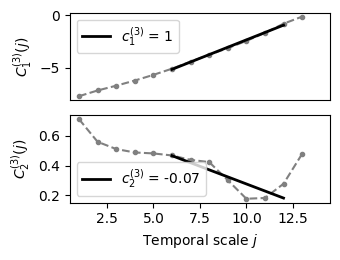

In [5]:
pwt = mfa(wavelet_analysis(mod["modulator"], 'db2').integrate(1).get_leaders(3), [(6, 12)])
pwt.cumulants.plot()

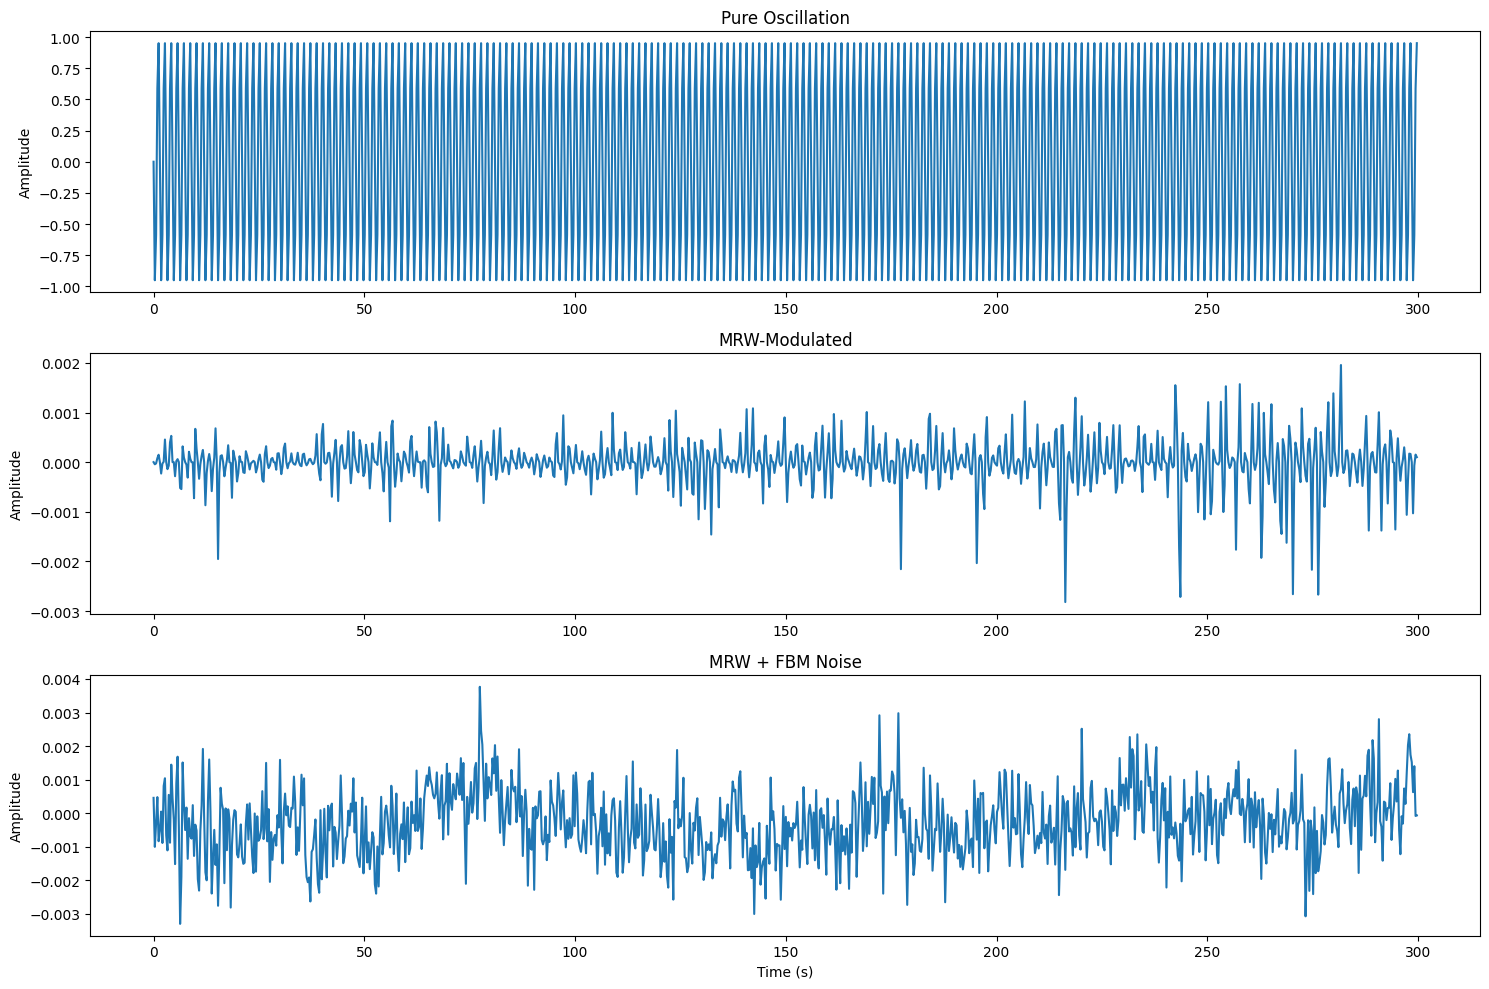

In [7]:
# Prepare data
signal_dicts = [pure, mrw_modulated, mrw_with_fbm]
titles = ["Pure Oscillation", "MRW-Modulated", "MRW + FBM Noise"]

fs = 250  # Sampling frequency
duration = 300
max_points = 1000


n_samples_to_plot = int(fs * duration)
t_full = signal_dicts[0]['time'][:n_samples_to_plot]


# Downsampling step
step = max(1, int(n_samples_to_plot / max_points)) if max_points is not None else 1
t = t_full[::step]

# Plot
plt.figure(figsize=(15, 10))

for i, (signal_dict, title) in enumerate(zip(signal_dicts, titles)):
    y_full = signal_dict['final_signal'][:n_samples_to_plot]
    y = y_full[::step]
    plt.subplot(len(signal_dicts), 1, i + 1)
    plt.plot(t, y)
    plt.title(title)
    plt.ylabel("Amplitude")
    if i == len(signal_dicts) - 1:
        plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()

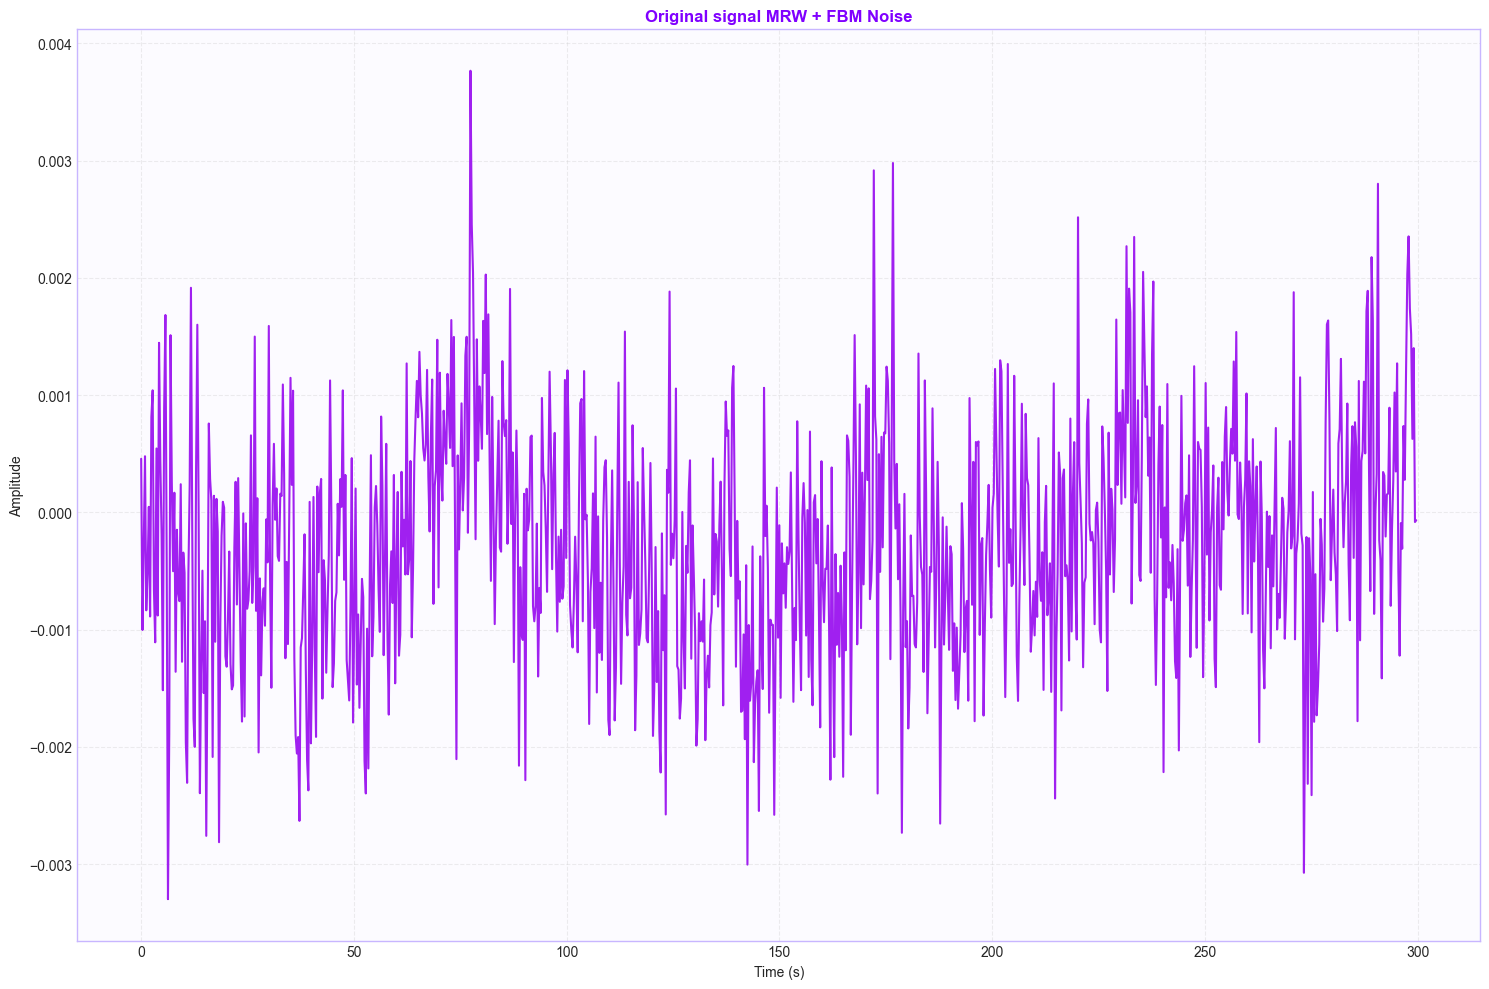

In [35]:
# # Define custom colors
# colors = ["#FF1493",  # Fuchsia (deep pink)
#           "#A020F0",  # Bright purple
#           "#1E90FF"]  # Bright blue (dodger blue)

# Prepare data
signal_dicts = [mrw_with_fbm]
titles = ["MRW + FBM Noise"]
# Define custom colors
colors = ["#A020F0"]  # Bright blue (dodger blue)

#signal_dicts = [pure, mrw_modulated, mrw_with_fbm]
#titles = ["Pure Oscillation", "MRW-Modulated", "MRW + FBM Noise"]


fs = 250  # Sampling frequency
duration = 300
max_points = 1000

n_samples_to_plot = int(fs * duration)
t_full = signal_dicts[0]['time'][:n_samples_to_plot]

# Downsampling step
step = max(1, int(n_samples_to_plot / max_points)) if max_points is not None else 1
t = t_full[::step]

# Plot
plt.figure(figsize=(15, 10))

for i, (signal_dict, title, color) in enumerate(zip(signal_dicts, titles, colors)):
    y_full = signal_dict['final_signal'][:n_samples_to_plot]
    y = y_full[::step]
    plt.subplot(len(signal_dicts), 1, i + 1)
    plt.plot(t, y, color=color)
    plt.title("Original signal MRW + FBM Noise")
    plt.ylabel("Amplitude")
    if i == len(signal_dicts) - 1:
        plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()


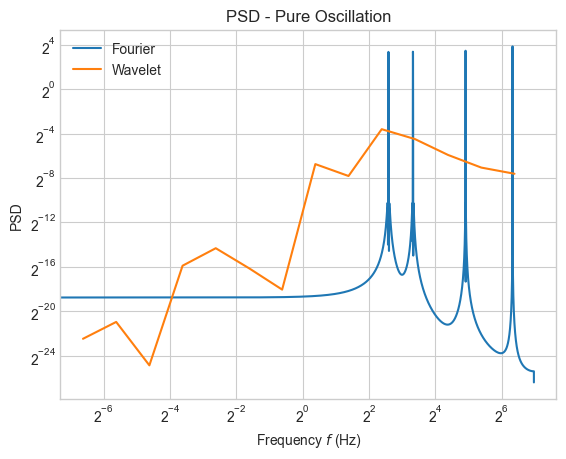

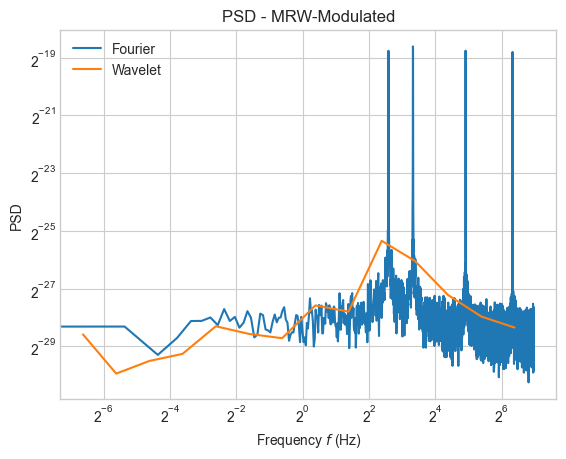

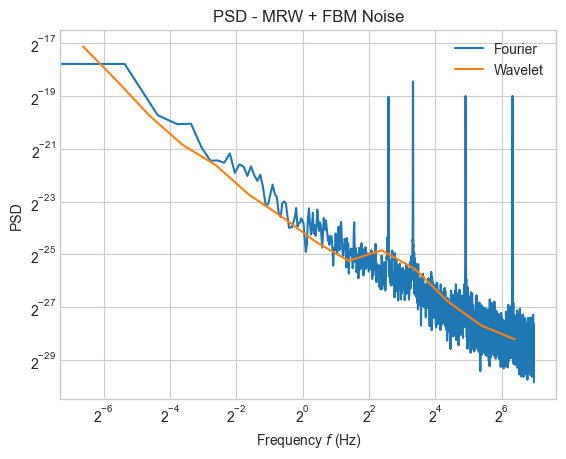

In [11]:
signal_list = [pure["final_signal"], mrw_modulated["final_signal"], mrw_with_fbm["final_signal"]]

for signal, title in zip(signal_list, titles):
    plot_psd_pm(signal, fs=fs)
    plt.title(f"PSD - {title}")
    plt.show()

## 3. Signal decomposition

### VMD Benchmark hyperparameters

In [106]:
import pickle
from sklearn.metrics import mean_absolute_error


# Choose based on the parameter you're testing
experiment_tag = "tau"  
save_path = f"../results/synthetic/benchmark_{experiment_tag}_results.pkl"

# Parameters
fs = 250
Nmodes_list = [5]
#alphas = [0, 50, 200, 500, 1000, 5000, 10000, 50000, 100000, 1000000,5000000]
alphas = [200]
taus = [0,0.5,1]
tols = [1e-7]
inits = [0]
DCs = [1]
tolerance = 2
expected_freqs = [6, 10, 30, 80]

param_grid = []
for Nm in Nmodes_list:
    for alpha in alphas:
        for tau in taus:
            for DC in DCs:
                for init in inits:
                    for tol in tols:
                        param_grid.append({
                            'Nmodes': Nm,
                            'alpha': alpha,
                            'tau': tau,
                            'DC': DC,
                            'init': init,
                            'tol': tol
                        })

# Helpers
def spectral_overlap_index(mode1, mode2, fs):
    f1, Pxx1 = periodogram(mode1, fs=fs)
    f2, Pxx2 = periodogram(mode2, fs=fs)
    if not np.allclose(f1, f2):
        raise ValueError("Frequency bins do not match.")
    num = np.sum(np.minimum(Pxx1, Pxx2))
    den = min(np.sum(Pxx1), np.sum(Pxx2))
    return 0.0 if den == 0 else num / den

def compute_soi_matrix(modes, fs):
    K = len(modes)
    soi = np.zeros((K, K))
    for i in range(K):
        for j in range(K):
            soi[i, j] = spectral_overlap_index(modes[i], modes[j], fs)
    mean_soi = np.mean(soi[np.triu_indices(K, k=1)])
    return soi, mean_soi

def peak_frequency(mode, fs):
    f, Pxx = periodogram(mode, fs=fs)
    if len(Pxx) == 0:
        return 0
    return f[np.argmax(Pxx)]

def test_vmd_params(signal, fs, param_grid, expected_freqs, tolerance=2.0):
    records = []
    spectra = {}
    for params in param_grid:
        Nm = params['Nmodes']
        alpha = params['alpha']
        tau = params['tau']
        DC = params['DC']
        init = params['init']
        tol = params['tol']
        IMFs, _, _ = VMD(signal, alpha, tau, Nm, DC, init, tol)
        reconstructed = np.sum(IMFs, axis=0)
        mae = mean_absolute_error(signal, reconstructed)
        _, mean_soi = compute_soi_matrix(IMFs, fs)
        peak_freqs = [peak_frequency(mode, fs) for mode in IMFs]
        all_covered = all(any(abs(pf - ef) <= tolerance for pf in peak_freqs) for ef in expected_freqs)
        record = {
            'Nmodes': Nm, 'alpha': alpha, 'tau': tau, 'DC': DC, 'init': init, 'tol': tol,
            'peak_frequencies': ', '.join(f"{pf:.2f}" for pf in peak_freqs),
            'all_covered': all_covered, 'mae': mae, 'mean_soi': mean_soi
        }
        records.append(record)
        key = (Nm, alpha, tau, DC, init, tol)
        spectra[key] = IMFs

    df = pd.DataFrame(records)
    return df, spectra

# Signal list
signal_list = [pure, mrw_modulated, mrw_with_fbm]
signal_names = ["pure", "mrw_modulated", "mrw_with_fbm"]

# Benchmark
all_results = []
benchmark_results = {}

for signal_dict, name in zip(signal_list, signal_names):
    signal = signal_dict['final_signal']
    print(f"\n🔍 Benchmarking signal: {name}")
    df_all, spectra = test_vmd_params(signal, fs, param_grid, expected_freqs, tolerance)
    df_all['signal'] = name
    all_results.append(df_all)
    benchmark_results[name] = {'df': df_all, 'spectra': spectra}

# Save
final_df = pd.concat(all_results, ignore_index=True)



🔍 Benchmarking signal: pure

🔍 Benchmarking signal: mrw_modulated

🔍 Benchmarking signal: mrw_with_fbm


In [107]:
with open(save_path, "wb") as f:
    pickle.dump(benchmark_results, f)


In [12]:
experiment_tag = "alpha"  
save_path = f"../results/synthetic/benchmark_{experiment_tag}_results.pkl"

with open(save_path, "rb") as f:
    data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../results/synthetic/benchmark_alpha_results.pkl'

In [158]:
data['mrw_with_fbm']['df'][data['mrw_with_fbm']['df']["all_covered"] == True].sort_values(by="mean_soi",ascending=True)


Nmodes  alpha  tau  DC  init           tol  \
1       5     50  0.5   1     0  1.000000e-07   
2       5    200  0.5   1     0  1.000000e-07   

                    peak_frequencies  all_covered       mae  mean_soi  \
1  6.00, 30.00, 10.00, 80.00, 116.92         True  0.000001  0.028518   
2  6.00, 30.00, 10.00, 80.00, 116.92         True  0.000001  0.028766   

         signal  
1  mrw_with_fbm  
2  mrw_with_fbm

In [108]:
final_df[final_df["all_covered"]==True].sort_values(by="mae",ascending=True)

Nmodes  alpha  tau  DC  init           tol  \
2       5    200  1.0   1     0  1.000000e-07   
1       5    200  0.5   1     0  1.000000e-07   
5       5    200  1.0   1     0  1.000000e-07   
8       5    200  1.0   1     0  1.000000e-07   
7       5    200  0.5   1     0  1.000000e-07   
4       5    200  0.5   1     0  1.000000e-07   
3       5    200  0.0   1     0  1.000000e-07   
6       5    200  0.0   1     0  1.000000e-07   
0       5    200  0.0   1     0  1.000000e-07   

                    peak_frequencies  all_covered           mae  mean_soi  \
2   6.00, 30.00, 10.00, 80.00, 80.00         True  7.244321e-10  0.200688   
1   6.00, 30.00, 10.00, 80.00, 80.00         True  2.703319e-09  0.200688   
5  6.00, 30.00, 10.00, 80.00, 117.99         True  1.000371e-06  0.025199   
8  6.00, 30.00, 10.00, 80.00, 116.92         True  1.357777e-06  0.028729   
7  6.00, 30.00, 10.00, 80.00, 116.92         True  1.402073e-06  0.028766   
4  6.00, 30.00, 10.00, 80.00, 117.99         True  3.202020e-06  0.025232   
3  6.00, 30.00, 10.00, 80.00, 111.61         True  8.454262e-05  0.019099   
6  6.00, 30.00, 10.00, 80.00, 110.31         True  1.037883e-04  0.021772   
0   6.00, 30.00, 10.00, 80.00, 80.00         True  9.922588e-03  0.200631   

          signal  
2           pure  
1           pure  
5  mrw_modulated  
8   mrw_with_fbm  
7   mrw_with_fbm  
4  mrw_modulated  
3  mrw_modulated  
6   mrw_with_fbm  
0           pure

In [ ]:
def plot_param_vs_metric(benchmark_results, signal_name, x_param='tau', metric='mae'):
    df = benchmark_results[signal_name]['df']

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x=x_param, y=metric, marker="o")

    plt.title(f"{metric.upper()} vs {x_param.upper()} — {signal_name}")
    plt.xlabel(x_param.upper())
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_mode_spectra_per_tau(
    benchmark_results, signal_name, fs, Nmodes, tau_values,
    alpha_fixed=200, DC=1, init=0, tol=1e-7
):
    spectra_dict = benchmark_results[signal_name]["spectra"]

    fig, axes = plt.subplots(
        len(tau_values), Nmodes,
        figsize=(4 * Nmodes, 2.5 * len(tau_values)),
        sharex=True, sharey=True
    )

    for i, tau in enumerate(tau_values):
        key = (Nmodes, alpha_fixed, tau, DC, init, tol)
        if key not in spectra_dict:
            print(f"⚠️ Missing key {key} — skipping.")
            continue

        modes = spectra_dict[key]
        for j in range(Nmodes):
            f, Pxx = welch(modes[j], fs=fs, nperseg=1024)
            ax = axes[i][j] if len(tau_values) > 1 else axes[j]
            ax.plot(f[1:], Pxx[1:])
            ax.set_xscale("log")
            ax.set_yscale("log")
            if j == 0:
                ax.set_ylabel(f"τ={tau}", fontsize=9)
            if i == len(tau_values) - 1:
                ax.set_xlabel("Frequency (Hz)")
            if i == 0:
                ax.set_title(f"Mode {j+1}", fontsize=9)

    fig.suptitle(f"Spectra of VMD Modes — {signal_name}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_mode_spectra_per_alpha(
    benchmark_results, signal_name, fs, Nmodes, alpha_values,
    tau_fixed=0.5, DC=1, init=0, tol=1e-7
):
    spectra_dict = benchmark_results[signal_name]["spectra"]

    fig, axes = plt.subplots(
        len(alpha_values), Nmodes,
        figsize=(4 * Nmodes, 2.5 * len(alpha_values)),
        sharex=True, sharey=True
    )

    for i, alpha in enumerate(alpha_values):
        key = (Nmodes, alpha, tau_fixed, DC, init, tol)
        if key not in spectra_dict:
            print(f"⚠️ Missing key {key} — skipping.")
            continue

        modes = spectra_dict[key]
        for j in range(Nmodes):
            f, Pxx = welch(modes[j], fs=fs, nperseg=1024)
            ax = axes[i][j] if len(alpha_values) > 1 else axes[j]
            ax.plot(f[1:], Pxx[1:])
            ax.set_xscale("log")
            ax.set_yscale("log")
            if j == 0:
                ax.set_ylabel(f"α={alpha}", fontsize=9)
            if i == len(alpha_values) - 1:
                ax.set_xlabel("Frequency (Hz)")
            if i == 0:
                ax.set_title(f"Mode {j+1}", fontsize=9)

    fig.suptitle(f"Spectra of VMD Modes — {signal_name}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



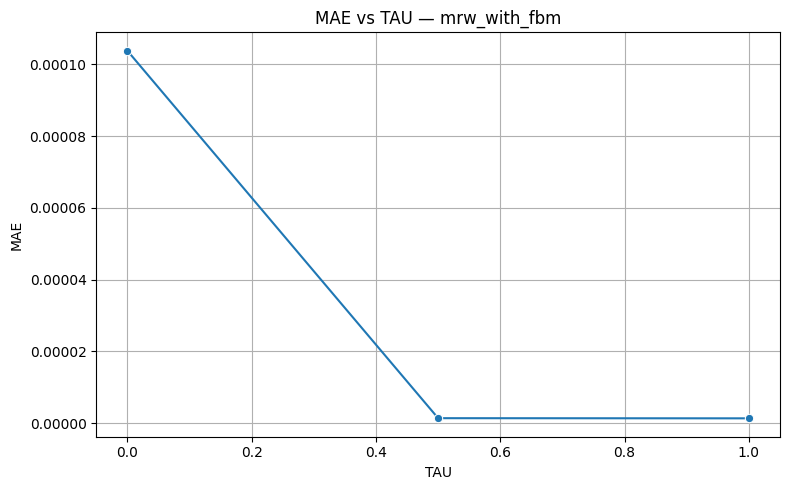

In [110]:
plot_param_vs_metric(benchmark_results, signal_name="mrw_with_fbm", x_param="tau", metric="mae")


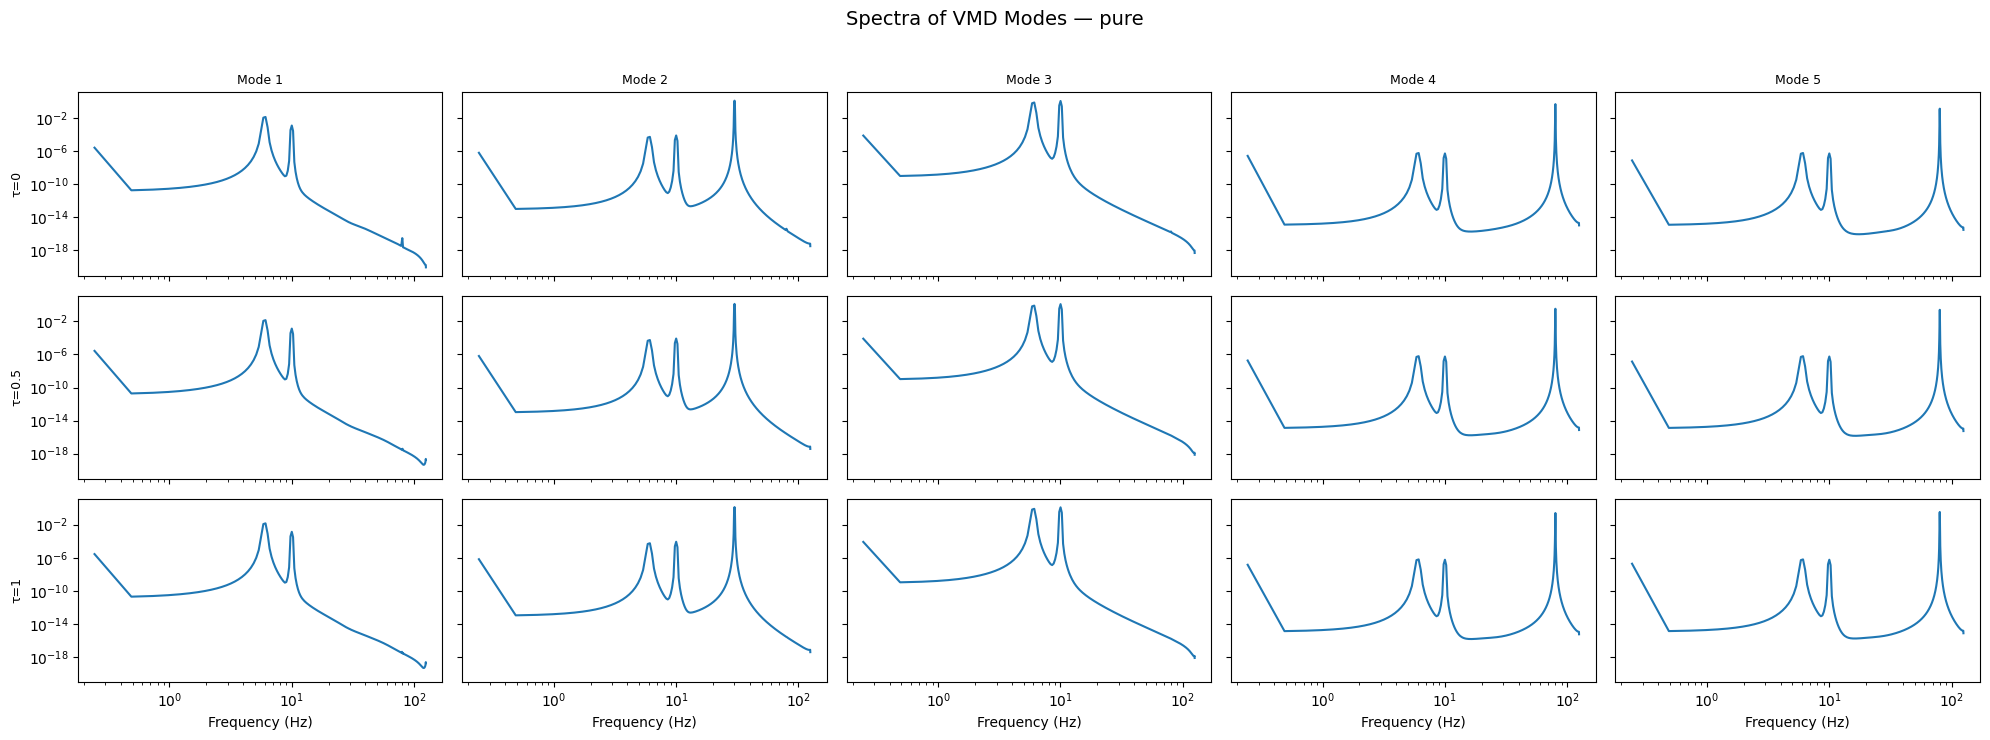

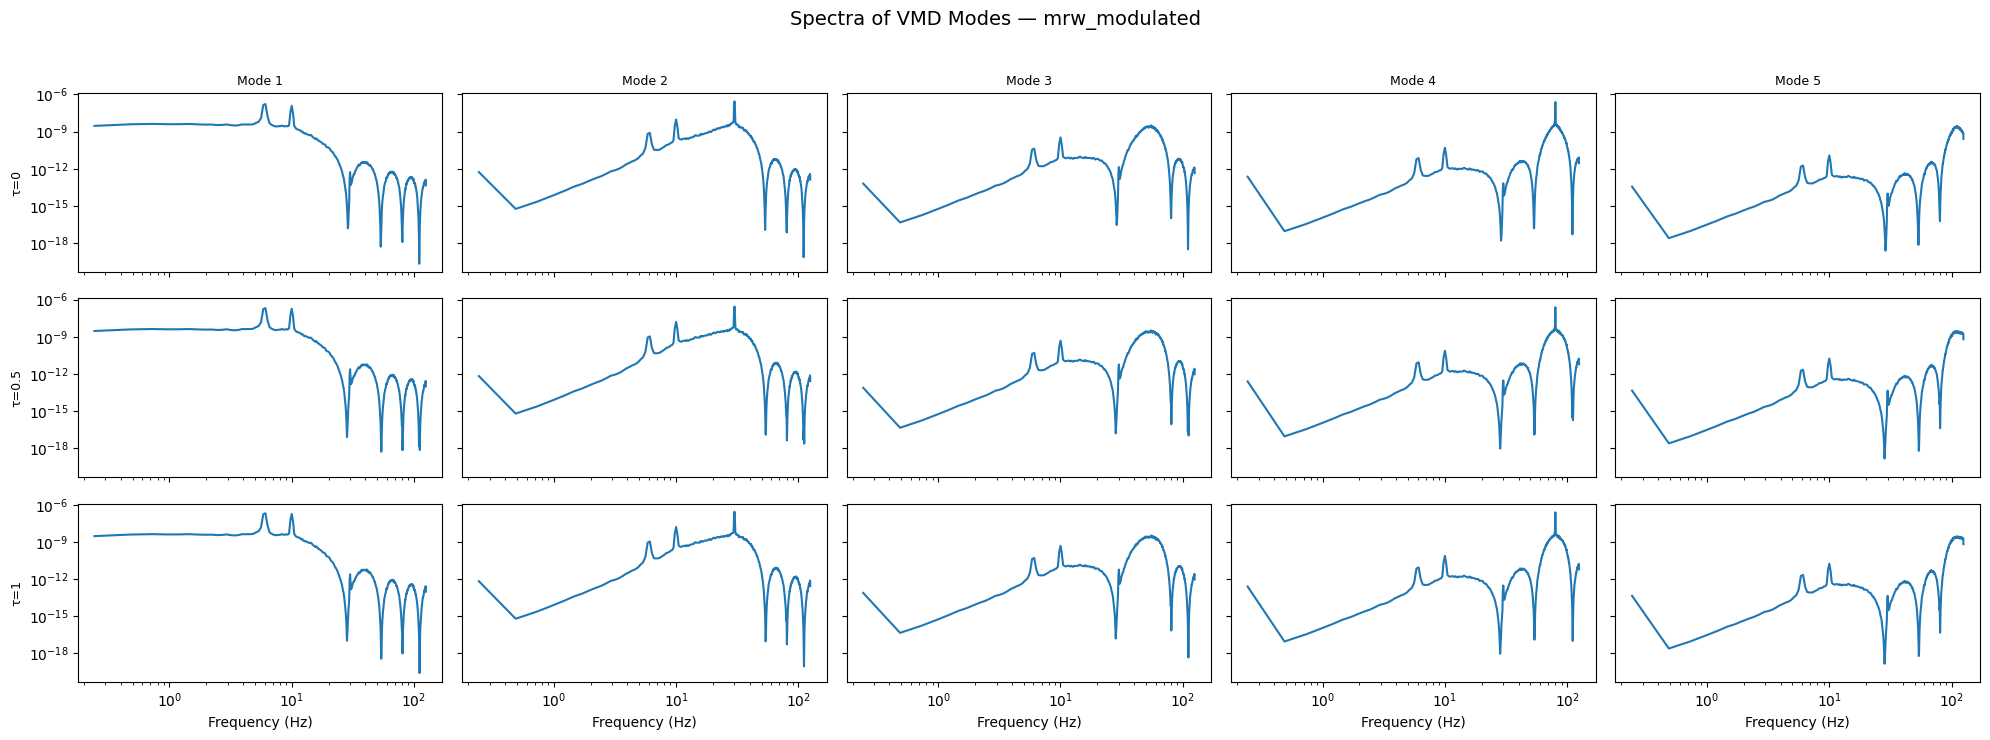

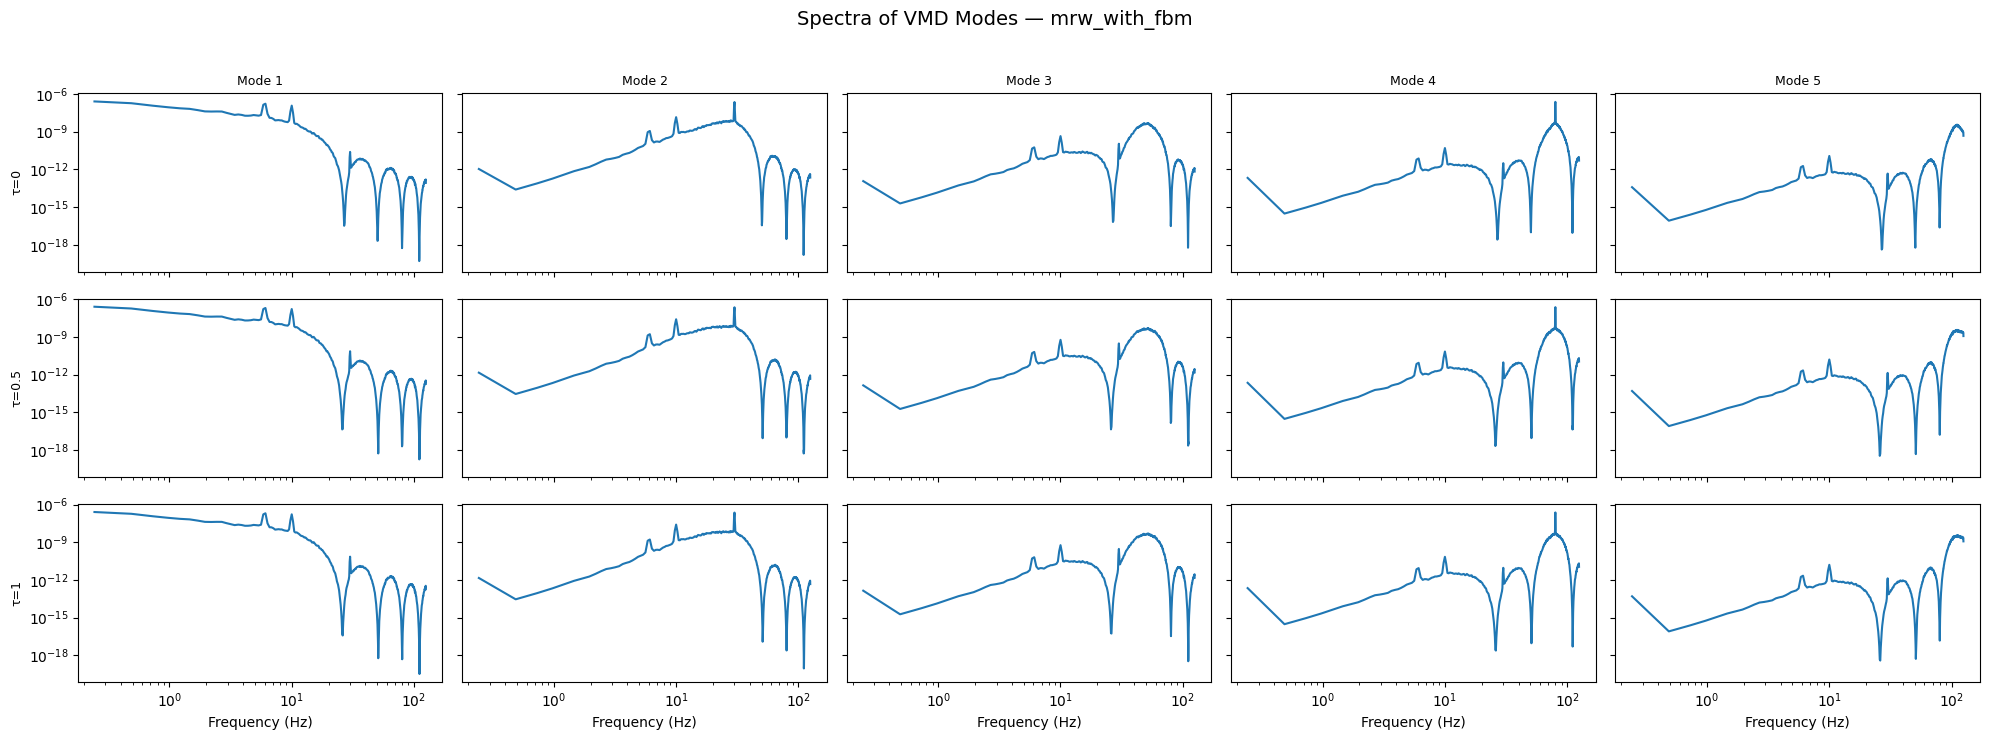

In [112]:
signal_names = ["pure", "mrw_modulated", "mrw_with_fbm"]

for name in signal_names:
    plot_mode_spectra_per_tau(
        benchmark_results,
        signal_name=name,
        fs=250,
        Nmodes=5,
        tau_values=[0, 0.5, 1],
        alpha_fixed=200
    )




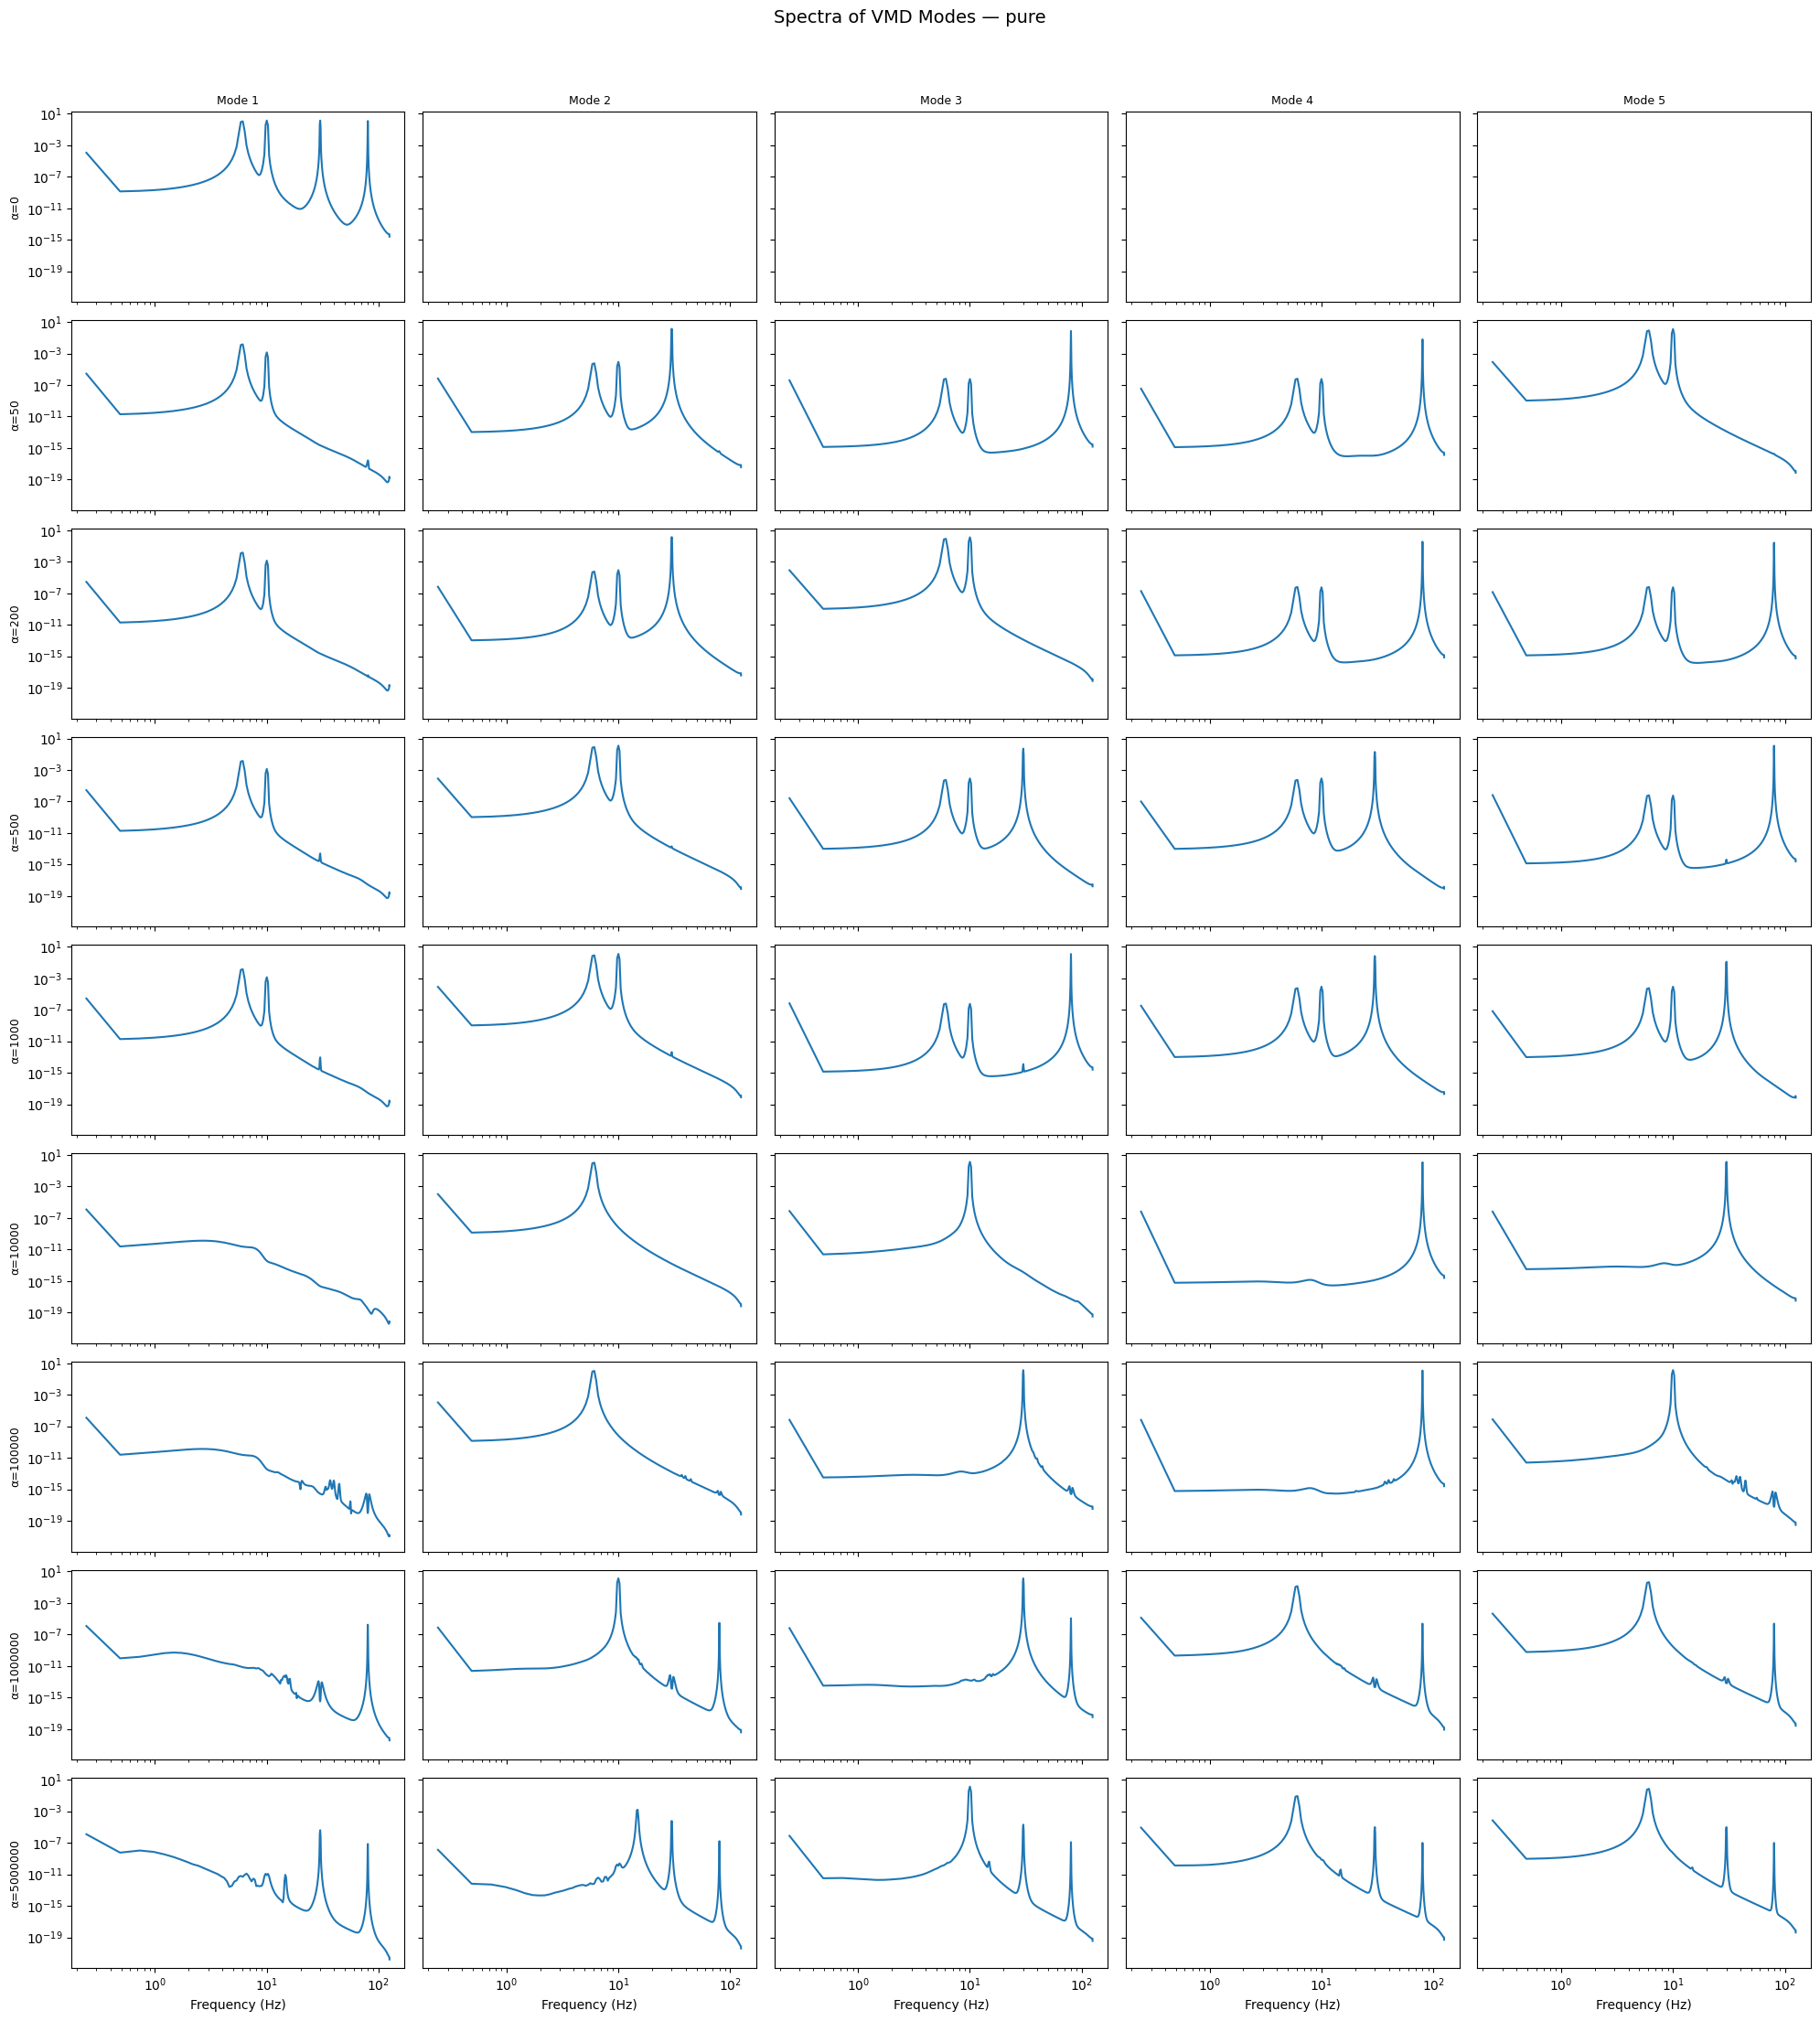

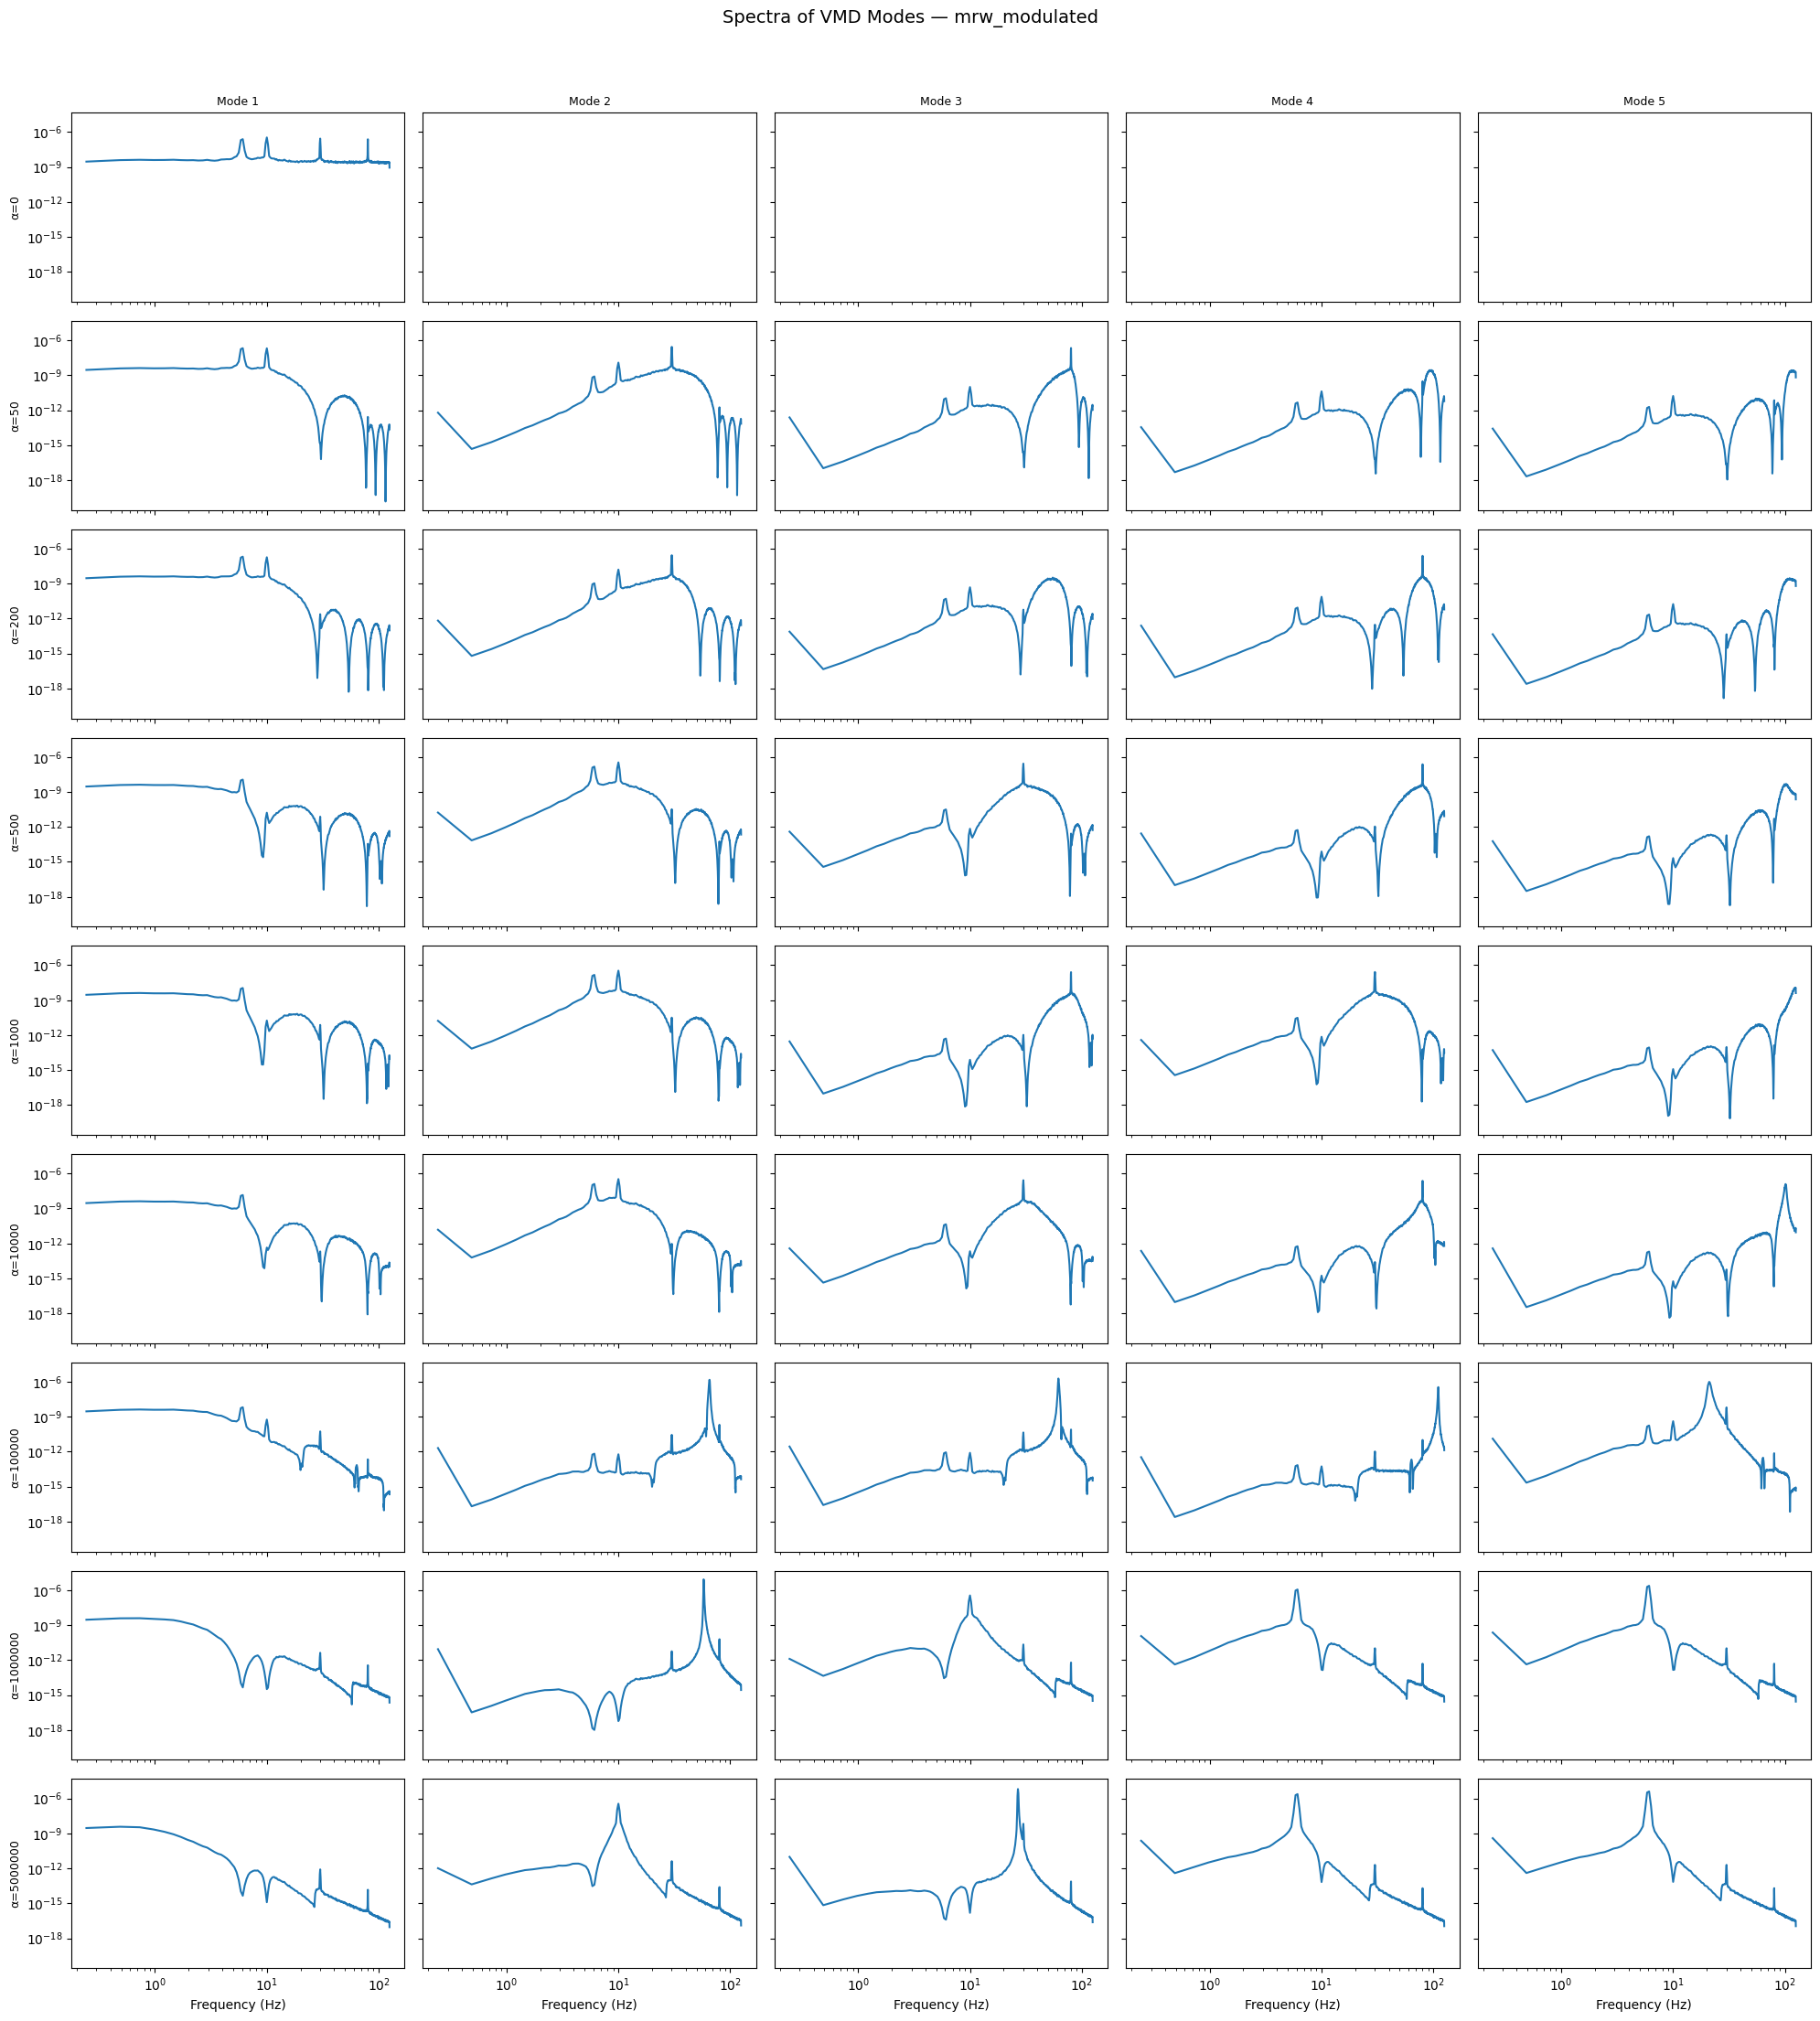

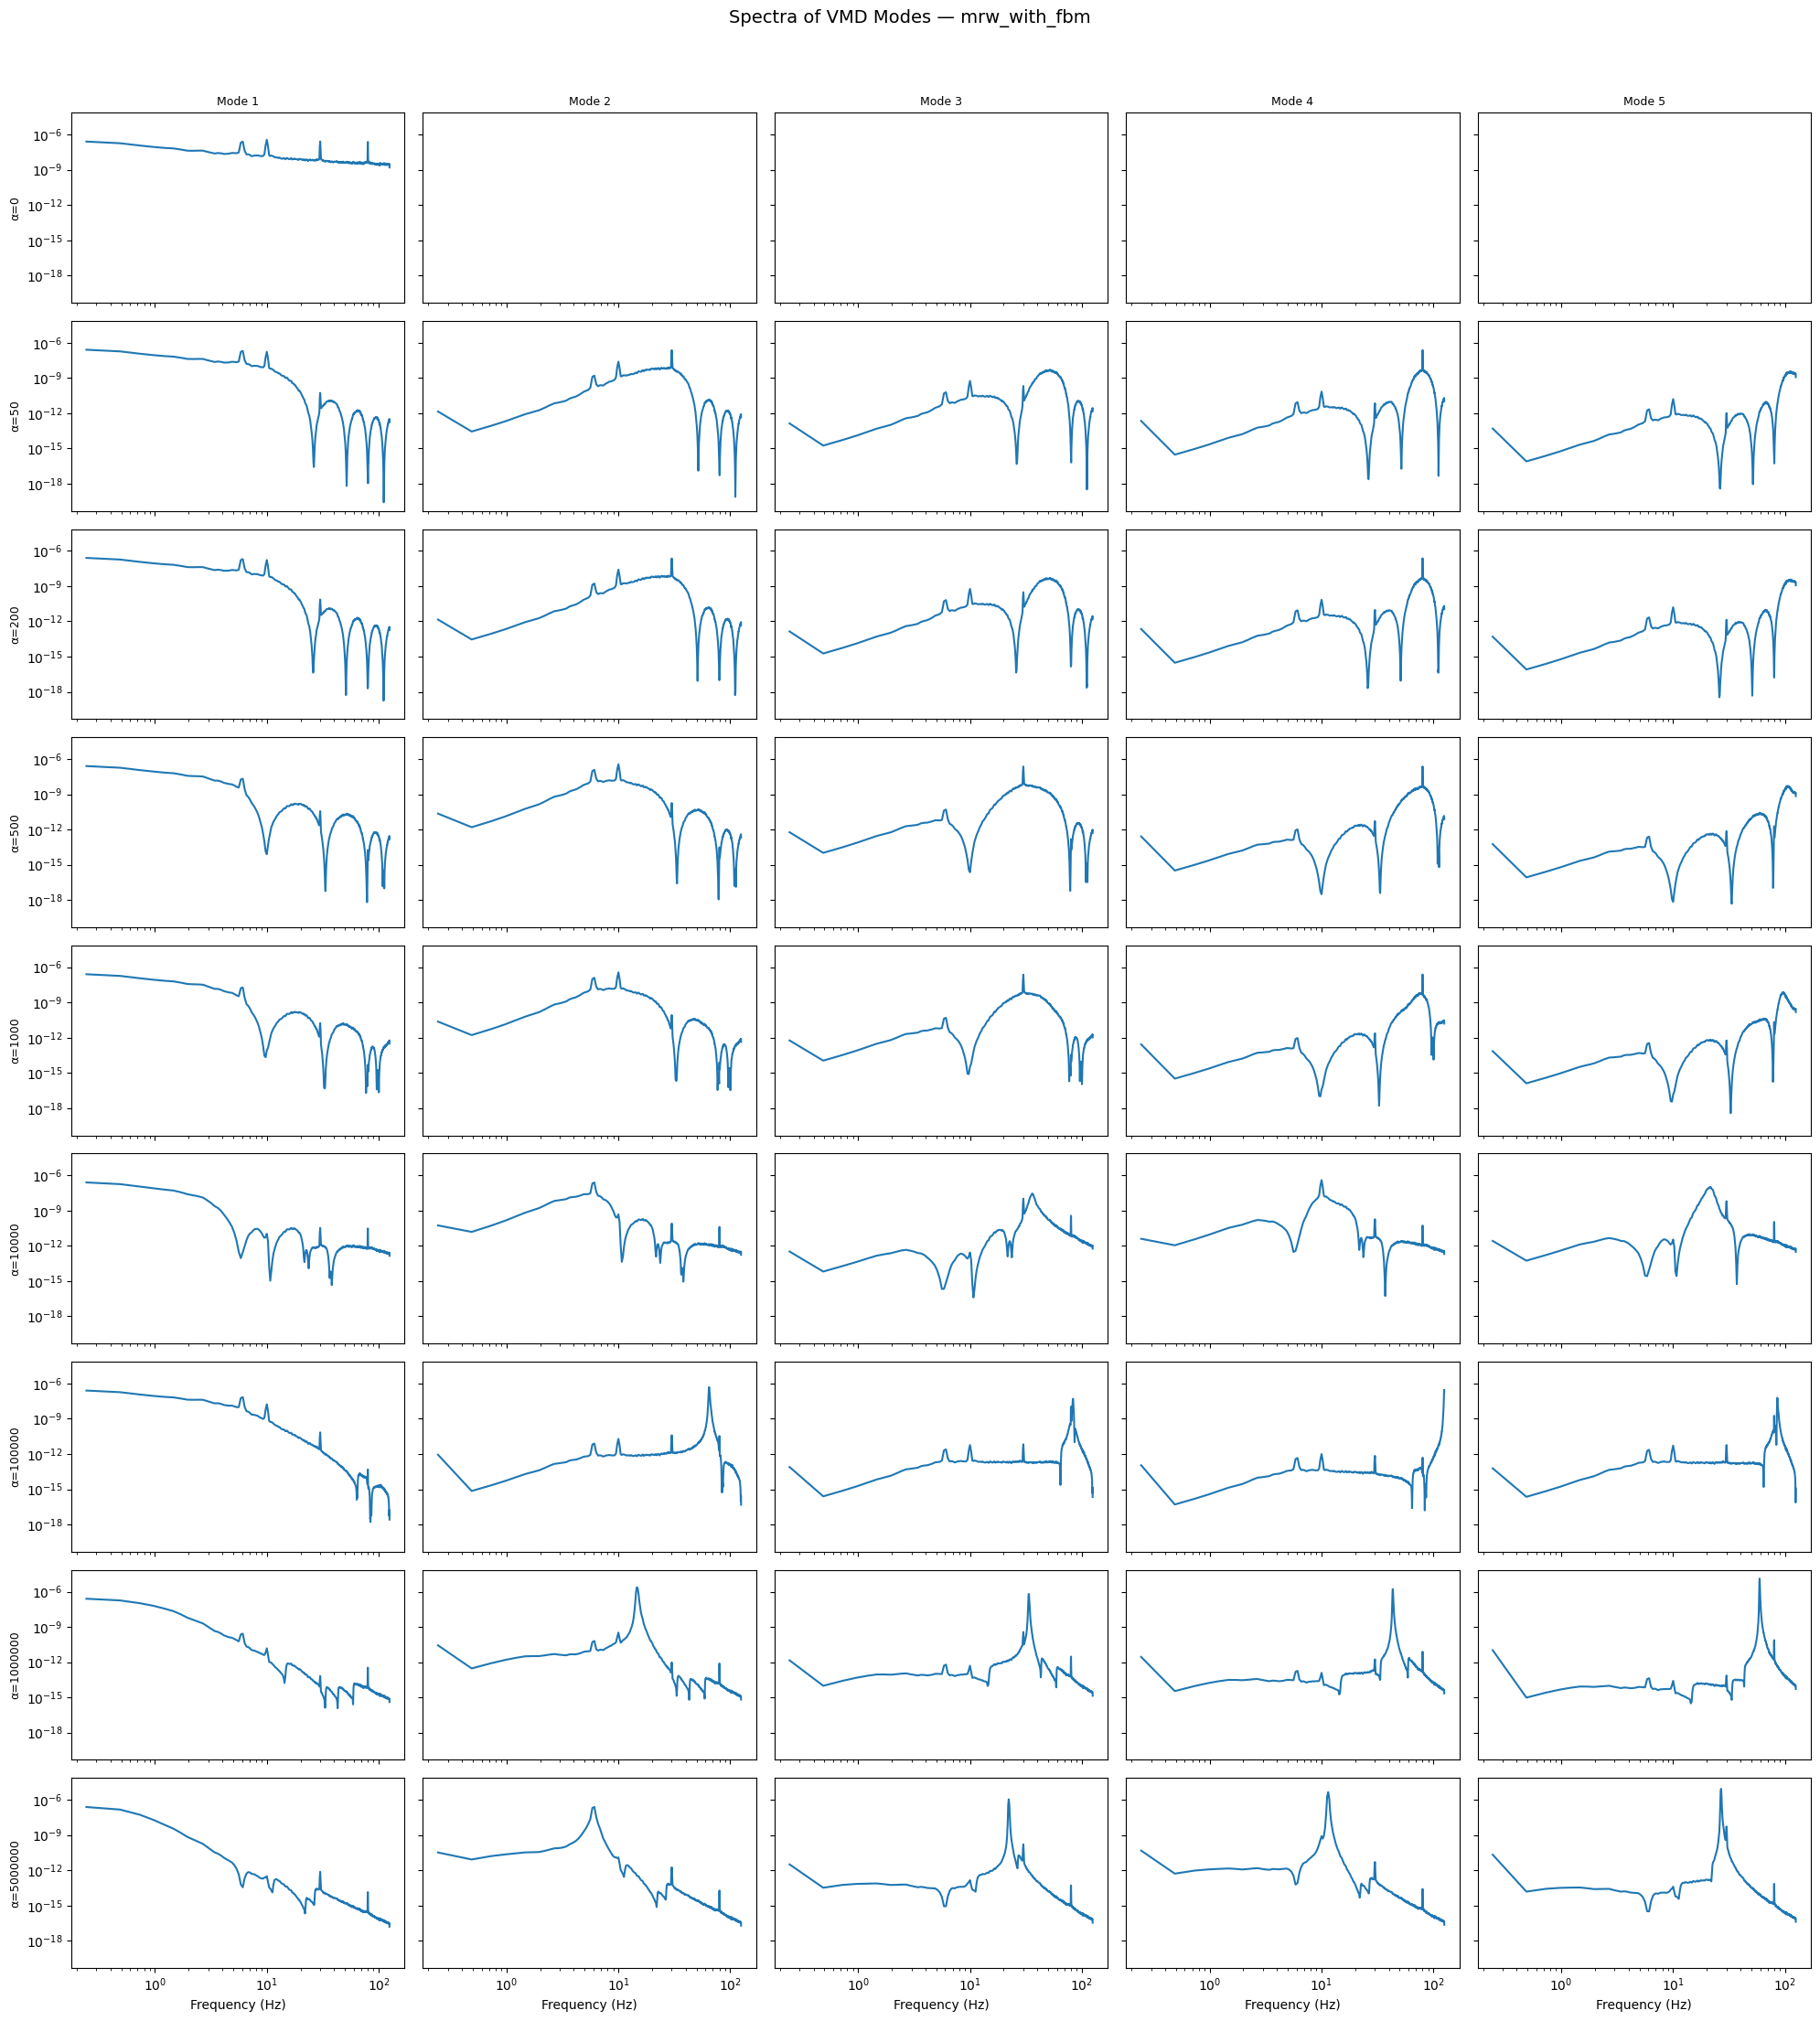

In [ ]:
signal_names = ["pure", "mrw_modulated", "mrw_with_fbm"]

for name in signal_names:
    plot_mode_spectra_per_alpha(
        benchmark_results=benchmark_results,
        signal_name=name,
        fs=250,
        Nmodes=5,
        alpha_values=[0, 50, 200, 500, 1000, 10000, 100000, 1000000, 5000000]
    )


### Set Parameters:

In [15]:
output_base = "../results/synthetic"
signal_list = [pure["final_signal"], mrw_modulated["final_signal"], mrw_with_fbm["final_signal"]]
signal_names = ["pure", "mrw_modulated", "mrw_with_fbm"]

# PARAMETERS
fs = 250  # Hz
duration = 300.0       # Duration to plot (in seconds)
max_points = 1000      # Optional: downsample to this number of points

In [17]:
# Run the decomposition
max_imfs = 8
max_modes = 5
n_modes = 5

best_vmd_params = {
    'pure': {'vmd_alpha': 100000, 'vmd_tau': 0.5, 'vmd_DC': 1, 'vmd_init': 0, 'vmd_tol': 1e-5, 'Nmodes': 5},
    'mrw_modulated': {'vmd_alpha': 200, 'vmd_tau': 0.5, 'vmd_DC': 1, 'vmd_init': 0, 'vmd_tol': 1e-7, 'Nmodes': 5},
    'mrw_with_fbm': {'vmd_alpha': 50, 'vmd_tau': 0.5, 'vmd_DC': 0, 'vmd_init': 0, 'vmd_tol': 1e-7, 'Nmodes': 5},
}

methods = [
        #"EMD",
        "VMD"
        #"VMDtransformer"
        ]

### Run the Decompositions:

In [147]:
for signal, name in zip(signal_list, signal_names):
    print(f"--- Decomposition for: {name} ---")
    output_dir = os.path.join(output_base, name)
    os.makedirs(output_dir, exist_ok=True)

    params = best_vmd_params.get(name, {})
    
    modes_dict = run_all_decompositions(
        signal_in=signal,
        methods=methods,
        Fs=fs,
        Nmodes=params.get('Nmodes', n_modes),
        MaxEmdIMF=max_imfs,
        MaxVmdModes=max_modes,
        vmd_alpha=params.get('vmd_alpha', 50),
        vmd_tau=params.get('vmd_tau', 0),
        vmd_DC=params.get('vmd_DC', 0),
        vmd_init=params.get('vmd_init', 0),
        vmd_tol=params.get('vmd_tol', 1e-7),
        return_modes=True
    )

    for method in methods:
        method_dir = os.path.join(output_dir, method)
        os.makedirs(os.path.join(method_dir, "modes"), exist_ok=True)

        # Save only modes here
        np.save(os.path.join(method_dir, "modes", f"{name}_modes.npy"), modes_dict[method])

        print(f"Saved modes for {method} of {name}")


--- Decomposition for: pure ---
VMD decomposition done in 18.11 seconds.
Saved modes for VMD of pure
--- Decomposition for: mrw_modulated ---
VMD decomposition done in 0.99 seconds.
Saved modes for VMD of mrw_modulated
--- Decomposition for: mrw_with_fbm ---
VMD decomposition done in 6.00 seconds.
Saved modes for VMD of mrw_with_fbm


In [150]:
# Extract the features
for name in signal_names:
    output_dir = os.path.join(output_base, name)

    for method in methods:
        modes_path = os.path.join(output_dir, method, "modes", f"{name}_modes.npy")
        features_path = os.path.join(output_dir, method, "features", f"{name}_features.csv")
        os.makedirs(os.path.dirname(features_path), exist_ok=True)

        compute_features_from_modes_and_save(modes_path, features_path, fs)


Features saved to ../results/synthetic/pure/VMD/features/pure_features.csv
Features saved to ../results/synthetic/mrw_modulated/VMD/features/mrw_modulated_features.csv
Features saved to ../results/synthetic/mrw_with_fbm/VMD/features/mrw_with_fbm_features.csv


In [152]:
# Generate the plot
for signal, name in zip(signal_list, signal_names):
    output_dir = os.path.join(output_base, name)

    for method in methods:
        modes_path = os.path.join(output_dir, method, "modes", f"{name}_modes.npy")
        modes = np.load(modes_path)

        plot_signal_and_modes(
            x=signal,
            sfreq=fs,
            modes=modes,
            method=method,
            ch=0,
            output_dir=output_dir,
            duration=300,
            max_points=1000,
            spectrum_method='windowed_fft'  # choose 'psd', 'fft', or 'windowed_fft' here
        )


In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, iirnotch, filtfilt
from math import ceil

# --- Optional notch filter (50/100 Hz by default) ---
def double_notch(x, fs, freqs=(50, 100), Q=30):
    """Apply notch filters at specified line freqs."""
    y = np.asarray(x, dtype=float)
    for f0 in freqs or []:
        b, a = iirnotch(w0=f0, Q=Q, fs=fs)
        y = filtfilt(b, a, y)
    return y

def _to_2d_modes(modes, ch=None, avg_channels=False):
    """
    Ensure modes have shape (n_modes, n_samples).
    Accepts (n_modes, n_samples) or (n_modes, n_samples, n_channels).
    """
    modes = np.asarray(modes)
    if modes.ndim == 2:
        return modes
    if modes.ndim == 3:
        if avg_channels:
            return modes.mean(axis=2)
        if ch is None:
            ch = 0
        return modes[:, :, ch]
    raise ValueError(f"Unsupported modes shape {modes.shape}; expected 2D or 3D array.")

def plot_mode_psds_from_disk(
    output_base,
    name,
    method,
    fs,
    nperseg=1024,
    log_y=True,
    max_freq=None,
    ch=None,
    avg_channels=False,
    apply_notch=True,
    notch_freqs=(50, 100),
    notch_Q=30,
    color="#8000FF",         # bright purple
    fill_alpha=0.15,
    layout_cols=3,
    suptitle=None,
):
    """
    Load modes from {output_base}/{name}/{method}/modes/{name}_modes.npy
    and plot PSD (Welch) for each mode in a tidy purple style.

    Parameters
    ----------
    output_base : str
    name        : str   (e.g., 'mrw_with_fbm')
    method      : str   (e.g., 'VMD' or 'EMD')
    fs          : float sampling frequency
    nperseg     : int   Welch window length
    log_y       : bool  plot in dB if True, else linear
    max_freq    : float limit x-axis (Hz); default Nyquist
    ch          : int   channel index if 3D modes (ignored if avg_channels=True)
    avg_channels: bool  average PSD across channels if 3D modes
    apply_notch : bool  apply 50/100 Hz notch (set freqs=None to disable)
    color       : str   line color in hex
    fill_alpha  : float transparency for a light underfill
    layout_cols : int   number of subplot columns
    suptitle    : str   figure super-title
    """
    modes_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
    if not os.path.exists(modes_path):
        raise FileNotFoundError(f"Modes file not found: {modes_path}")

    modes = np.load(modes_path, allow_pickle=False)
    modes_2d = _to_2d_modes(modes, ch=ch, avg_channels=avg_channels)  # (n_modes, n_samples)

    n_modes, n_samples = modes_2d.shape
    if max_freq is None:
        max_freq = fs / 2.0

    # Matplotlib styling (no seaborn needed)
    plt.rcParams.update({
        "axes.facecolor": "#FCFBFF",         # very light lilac background
        "figure.facecolor": "white",
        "axes.grid": True,
        "grid.alpha": 0.35,
        "grid.linestyle": "--",
        "axes.edgecolor": "#C8B6FF",
        "axes.titleweight": "bold",
        "axes.titlecolor": color,
    })

    rows = ceil(n_modes / layout_cols)
    fig, axes = plt.subplots(rows, layout_cols, figsize=(5.2*layout_cols, 3.6*rows), sharex=True, sharey=True)
    axes = np.atleast_2d(axes)

    # Precompute PSDs per mode
    psd_list = []
    for k in range(n_modes):
        sig = modes_2d[k]
        if apply_notch:
            sig = double_notch(sig, fs, freqs=notch_freqs, Q=notch_Q)

        f, Pxx = welch(sig, fs=fs, nperseg=min(nperseg, len(sig)))
        mask = (f > 0) & (f <= max_freq)
        f, Pxx = f[mask], Pxx[mask]

        if log_y:
            y = 10 * np.log10(np.maximum(Pxx, 1e-30))
        else:
            y = Pxx

        psd_list.append((f, y))

    # Normalize axis ranges across subplots
    all_y = np.concatenate([y for _, y in psd_list]) if psd_list else np.array([0])
    y_min, y_max = float(all_y.min()), float(all_y.max())
    pad = 0.05 * (y_max - y_min + 1e-12)
    y_min, y_max = y_min - pad, y_max + pad

    # Plot
    for idx, (ax) in enumerate(axes.flat):
        if idx < n_modes:
            f, y = psd_list[idx]
            # light underfill in a softer purple
            ax.fill_between(f, y, y.min(), color=color, alpha=fill_alpha, linewidth=0)
            ax.plot(f, y, color=color, linewidth=1.8, label=f"Mode {idx}")
            ax.set_title(f"Mode {idx}", fontsize=12)
            ax.set_ylim([y_min, y_max])
            ax.set_xlim([f.min(), max_freq])
            if idx % layout_cols == 0:
                ax.set_ylabel("Power (dB)" if log_y else "Power")
        else:
            ax.axis("off")

    for ax in axes[-1, :]:
        ax.set_xlabel("Frequency (Hz)")

    if suptitle is None:
        suptitle = f"{method} PSDs • {name} " + ("(avg across channels)" if avg_channels else (f"(ch={ch})" if modes.ndim == 3 else ""))
    fig.suptitle(suptitle, fontsize=14, color=color, fontweight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


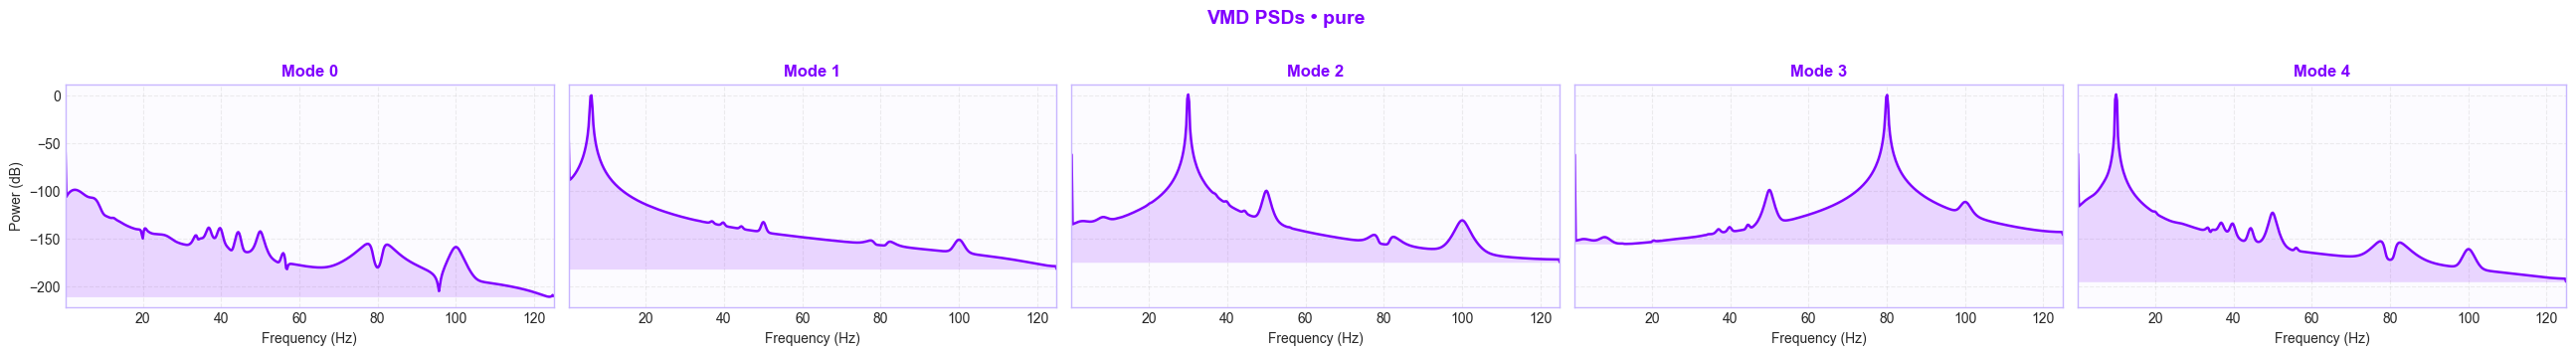

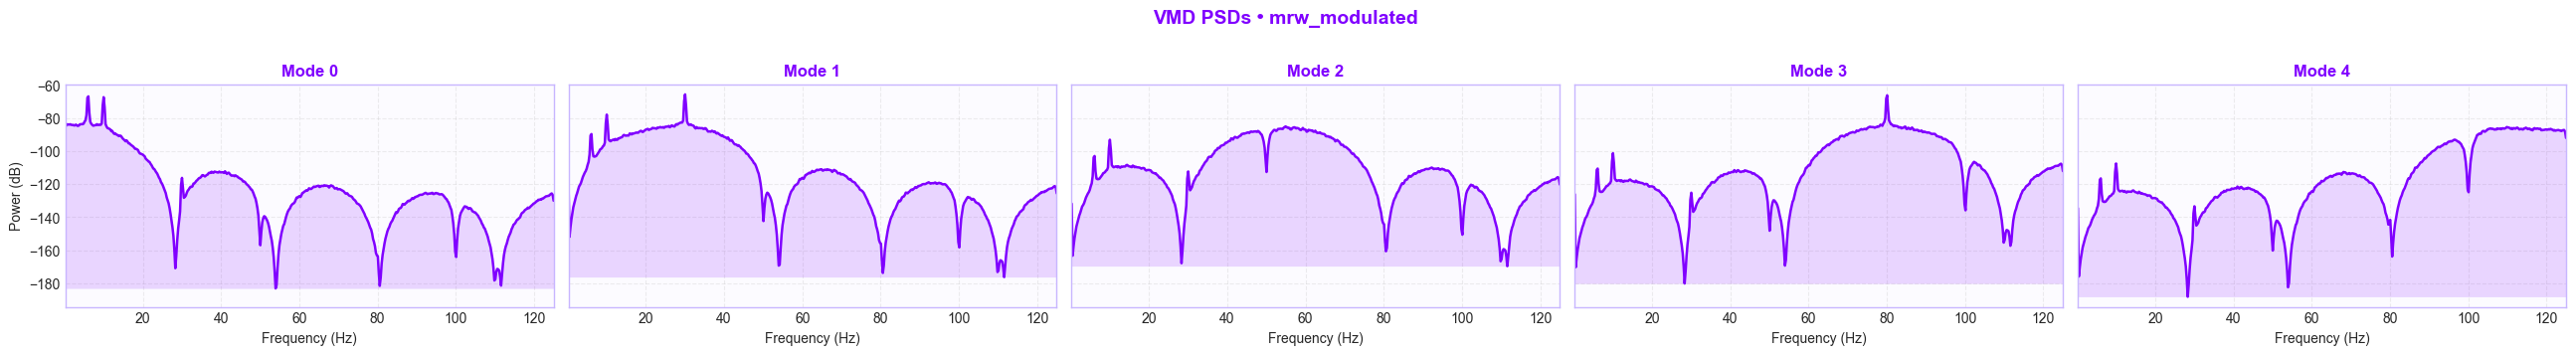

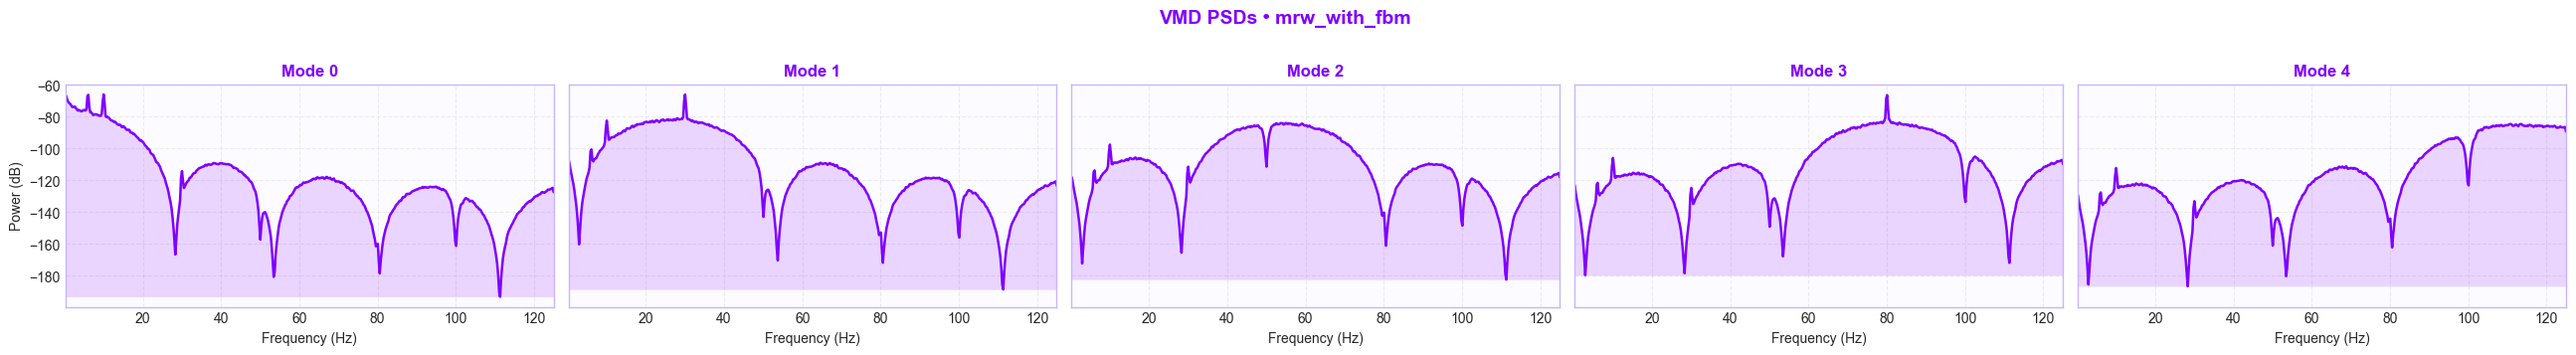

In [52]:
for signal, name in zip(signal_list, signal_names):
    output_dir = os.path.join(output_base, name)
    for method in methods:
        # keep your existing plot call if you want
        # plot_signal_and_modes(...)

        # add a pretty PSD grid per mode:
        plot_mode_psds_from_disk(
            output_base=output_base,  # base path above all names
            name=name,
            method=method,
            fs=fs,
            nperseg=1024,
            log_y=True,           # dB scale
            max_freq=125,         # or fs/2
            ch=0,                 # if 3D modes and you want a specific channel
            avg_channels=False,   # set True to average channels if present
            apply_notch=True,     # notch out 50/100 Hz lines
            notch_freqs=(50, 100),
            color="#8000FF",      # bright purple
            layout_cols=5,        # grid columns
            suptitle=None,
        )


### Summarize the Results:

In [223]:
report_df = summarize_decomposition_results(
    signal_list=signal_list,          # list of signals you processed
    signal_names=signal_names,        # corresponding names
    sfreq=250,                        # your sampling frequency
    base_dir="../results/synthetic",     # change if you're saving somewhere else
    n_modes_to_use=None                  # how many modes to use in partial reconstruction
)


In [224]:
#report_df.to_csv("../results/synthetic/report_synthetic.csv", index=False, mode="a" )
report_df.to_csv("../results/synthetic/report_synthetic.csv", index=False )

In [225]:
report_df[report_df["Method"].isin(["EMD","VMD"])].head(100)


Method         Signal  Mode Index  Peak Frequency (Hz)  \
0     EMD           pure           0            80.000000   
1     EMD           pure           1            30.000000   
2     EMD           pure           2            10.000000   
3     EMD           pure           3             6.000000   
4     EMD           pure           4             2.000000   
5     EMD           pure           5             0.096970   
6     EMD           pure           6             0.100000   
7     EMD           pure           7             0.063636   
8     EMD           pure           8             0.012121   
9     EMD  mrw_modulated           0            80.000000   
10    EMD  mrw_modulated           1            30.000000   
11    EMD  mrw_modulated           2            30.000000   
12    EMD  mrw_modulated           3            10.000000   
13    EMD  mrw_modulated           4             6.000000   
14    EMD  mrw_modulated           5             6.000000   
15    EMD  mrw_modulated           6             2.078788   
16    EMD  mrw_modulated           7             1.072727   
17    EMD  mrw_modulated           8             0.151515   
18    EMD   mrw_with_fbm           0            80.000000   
19    EMD   mrw_with_fbm           1            30.000000   
20    EMD   mrw_with_fbm           2            30.000000   
21    EMD   mrw_with_fbm           3            10.000000   
22    EMD   mrw_with_fbm           4             6.000000   
23    EMD   mrw_with_fbm           5             6.000000   
24    EMD   mrw_with_fbm           6             1.518182   
25    EMD   mrw_with_fbm           7             0.775758   
26    EMD   mrw_with_fbm           8             0.006061   
27    VMD           pure           0             6.000000   
28    VMD           pure           1            30.000000   
29    VMD           pure           2            80.000000   
30    VMD           pure           3            80.000000   
31    VMD           pure           4            10.000000   
32    VMD  mrw_modulated           0             6.000000   
33    VMD  mrw_modulated           1            10.000000   
34    VMD  mrw_modulated           2            30.000000   
35    VMD  mrw_modulated           3            80.000000   
36    VMD  mrw_modulated           4           105.845455   
37    VMD   mrw_with_fbm           0             6.000000   
38    VMD   mrw_with_fbm           1            30.000000   
39    VMD   mrw_with_fbm           2            80.000000   
40    VMD   mrw_with_fbm           3            80.000000   
41    VMD   mrw_with_fbm           4           110.927273   

    Reconstruction MSE (Full)  Reconstruction MSE (First N Modes)  \
0                2.561758e-40                        2.561758e-40   
1                2.561758e-40                        2.561758e-40   
2                2.561758e-40                        2.561758e-40   
3                2.561758e-40                        2.561758e-40   
4                2.561758e-40                        2.561758e-40   
5                2.561758e-40                        2.561758e-40   
6                2.561758e-40                        2.561758e-40   
7                2.561758e-40                        2.561758e-40   
8                2.561758e-40                        2.561758e-40   
9                3.022932e-36                        3.022932e-36   
10               3.022932e-36                        3.022932e-36   
11               3.022932e-36                        3.022932e-36   
12               3.022932e-36                        3.022932e-36   
13               3.022932e-36                        3.022932e-36   
14               3.022932e-36                        3.022932e-36   
15               3.022932e-36                        3.022932e-36   
16               3.022932e-36                        3.022932e-36   
17               3.022932e-36                        3.022932e-36   
18               8.302278e-34                        8.302278e-34   

| # | Feature               | Code Label  | Description                                                                 |
|---|-----------------------|-------------|-----------------------------------------------------------------------------|
| 1 | Spectral Entropy      | `ent`       | Measures complexity of frequency content — high entropy = noisy modes       |
| 2 | Spectral Power        | `Pfreq`     | Total energy in the mode's spectrum — higher means more meaningful signal   |
| 3 | Peak Frequency (Hz)   | `Ppeak`     | Frequency with maximum power — indicates which rhythm is captured           |
| 4 | Hjorth Mobility       | `Hmob`      | Indicates dominant frequency — higher means faster oscillations             |
| 5 | Hjorth Complexity     | `Hcomp`     | Describes structural irregularity — high = more complex or unstable signal  |


Method  Mode Index        EMD   VMD
0                0  80.000000   6.0
1                1  30.000000  30.0
2                2  10.000000  80.0
3                3   6.000000  80.0
4                4   2.000000  10.0
5                5   0.096970   NaN
6                6   0.100000   NaN
7                7   0.063636   NaN
8                8   0.012121   NaN

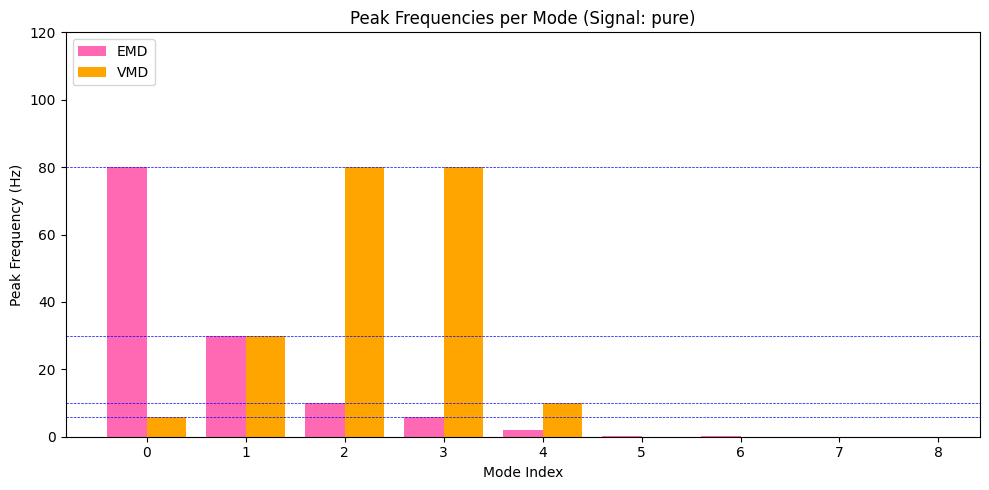

Method  Mode Index        EMD         VMD
0                0  80.000000    6.000000
1                1  30.000000   10.000000
2                2  30.000000   30.000000
3                3  10.000000   80.000000
4                4   6.000000  105.845455
5                5   6.000000         NaN
6                6   2.078788         NaN
7                7   1.072727         NaN
8                8   0.151515         NaN

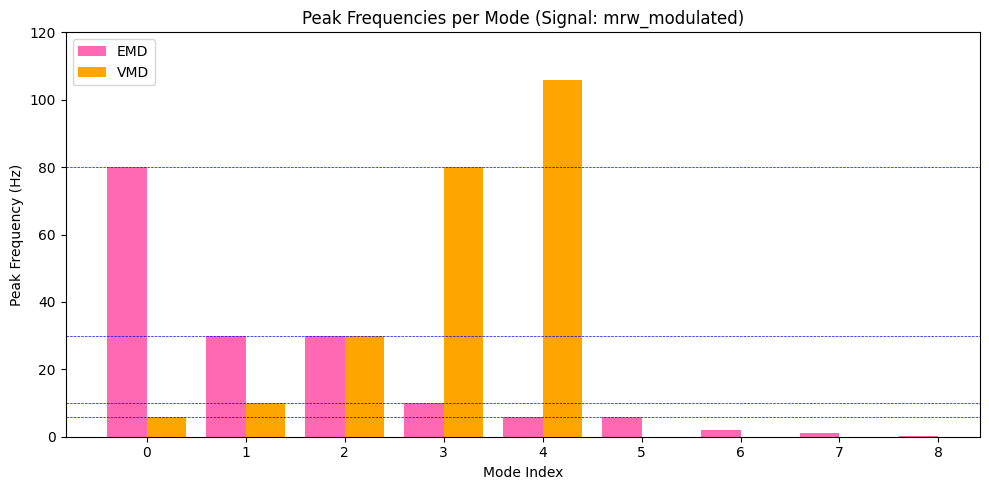

Method  Mode Index        EMD         VMD
0                0  80.000000    6.000000
1                1  30.000000   30.000000
2                2  30.000000   80.000000
3                3  10.000000   80.000000
4                4   6.000000  110.927273
5                5   6.000000         NaN
6                6   1.518182         NaN
7                7   0.775758         NaN
8                8   0.006061         NaN

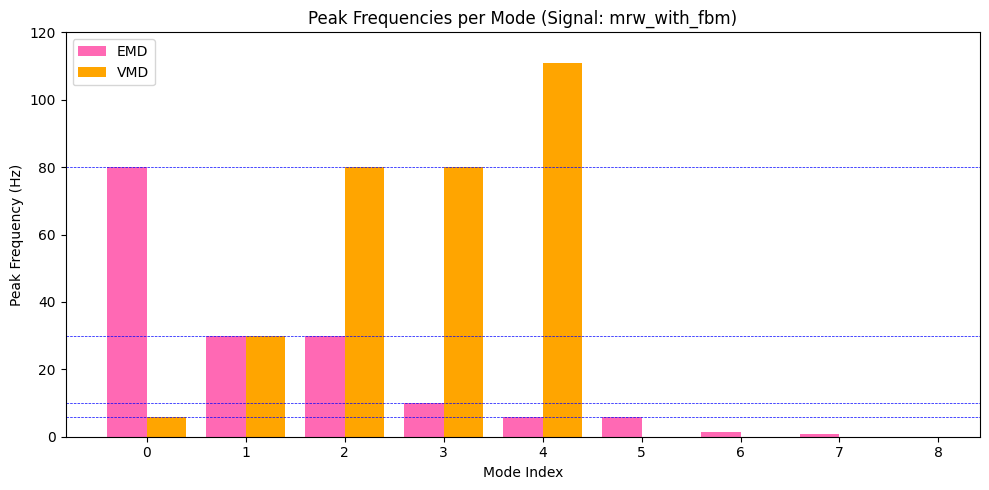

In [ ]:
colors = {
    "EMD": "#FF69B4",   # pink
    "VMD": "#FFA500"    # orange
}

signals = report_df["Signal"].unique()
for signal in signals:
    df_sig = report_df[report_df["Signal"] == signal].copy()

    # Align bars: group by mode index and pivot so that EMD and VMD are columns
    pivot_df = df_sig.pivot(index="Mode Index", columns="Method", values="Peak Frequency (Hz)").reset_index()
    pivot_df = pivot_df.sort_values("Mode Index")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    width = 0.4  # width of bars
    x = pivot_df["Mode Index"]

    ax.bar(x - width/2, pivot_df["EMD"], width=width, label="EMD", color=colors["EMD"])
    ax.bar(x + width/2, pivot_df["VMD"], width=width, label="VMD", color=colors["VMD"])

    # Add horizontal lines for target frequencies
    for freq in [6, 10, 30, 80]:
        ax.axhline(freq, linestyle="--", color="blue", linewidth=0.5)

    ax.set_title(f"Peak Frequencies per Mode (Signal: {signal})")
    ax.set_xlabel("Mode Index")
    ax.set_ylabel("Peak Frequency (Hz)")
    ax.set_ylim(0, 120)
    ax.set_xticks(x)
    ax.legend()
    plt.tight_layout()
    plt.show()


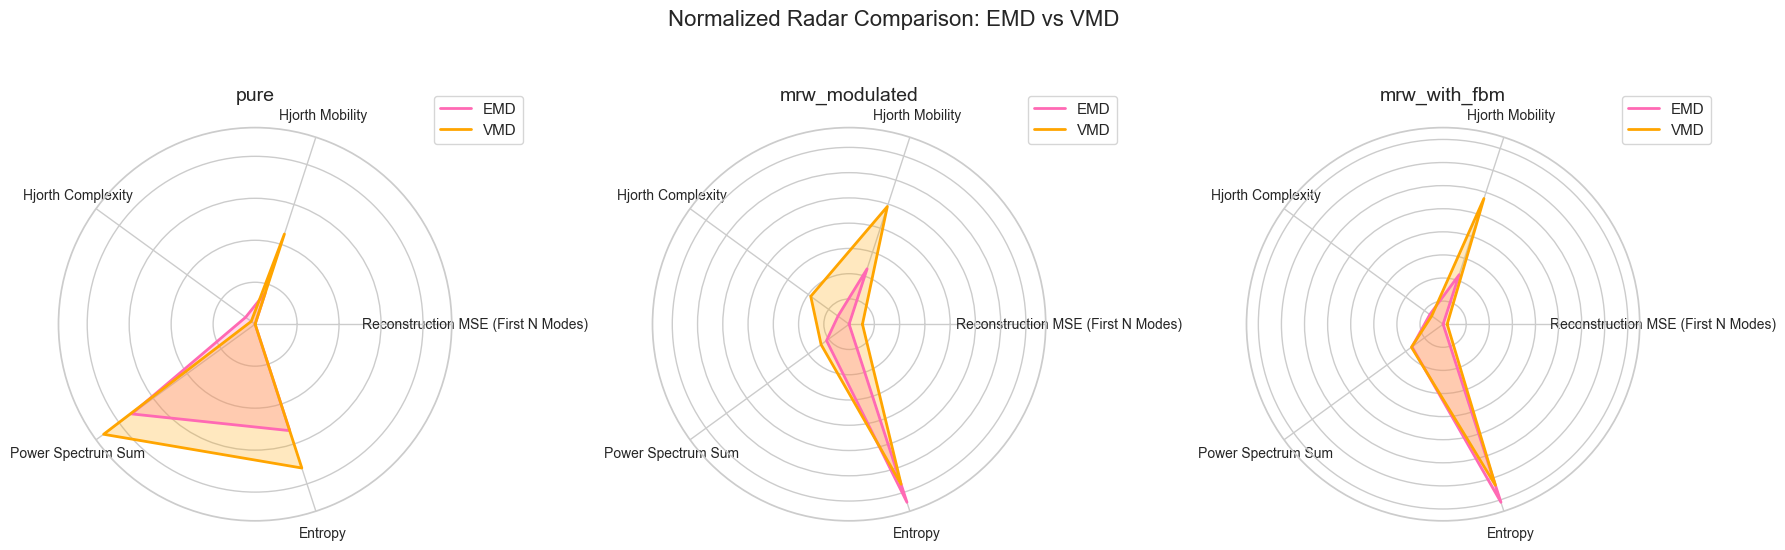

In [ ]:

# Select relevant features for radar plot
radar_features = [
    "Reconstruction MSE (First N Modes)",
    "Hjorth Mobility",
    "Hjorth Complexity",
    "Power Spectrum Sum",
    "Entropy"
]

# Copy df to avoid modifying original
df_plot = report_df.copy()

# Normalize selected features to [0,1]
df_plot["Power Spectrum Sum"] = np.log10(report_df["Power Spectrum Sum"] + 1e-10)
scaler = MinMaxScaler()
df_plot[radar_features] = scaler.fit_transform(df_plot[radar_features])

# Invert MSE so higher is better (1 - normalized MSE)
#df_plot["Reconstruction MSE (First N Modes)"] = 1 - df_plot["Reconstruction MSE (First N Modes)"]


# Plot setup
signals = df_plot["Signal"].unique()
angles = np.linspace(0, 2 * np.pi, len(radar_features), endpoint=False).tolist()
angles += angles[:1]  # close the loop

colors = {
    "EMD": "#FF69B4",   # pink
    "VMD": "#FFA500"    # orange
}

fig, axs = plt.subplots(1, len(signals), figsize=(18, 6), subplot_kw=dict(polar=True))

for i, signal in enumerate(signals):
    ax = axs[i]
    for method in ["EMD", "VMD"]:
        subset = df_plot[(df_plot["Signal"] == signal) & (df_plot["Method"] == method)]
        if not subset.empty:
            values = subset[radar_features].mean().tolist()
            values += values[:1]  # close the radar plot
            ax.plot(angles, values, label=method, color=colors[method], linewidth=2)
            ax.fill(angles, values, color=colors[method], alpha=0.25)

    ax.set_title(signal, size=14, pad=20)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_features, fontsize=10)
    ax.set_yticklabels([])
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

plt.suptitle("Normalized Radar Comparison: EMD vs VMD", fontsize=16)
plt.tight_layout()
plt.savefig("radar_horizontal_emd_vmd.png", dpi=300)
plt.show()


## 3. Apply the MFA:

<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?


Processing signal: mrw_modulated


/var/folders/_p/stbgbx154_v2mk71nn05yw5r0000gn/T/ipykernel_49278/2093096099.py:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if name is not "pure":


<Figure size 800x400 with 0 Axes>

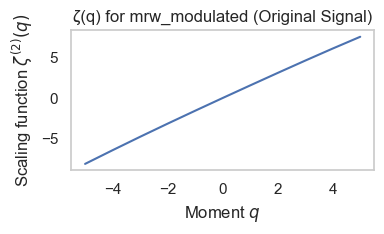

<Figure size 800x400 with 0 Axes>

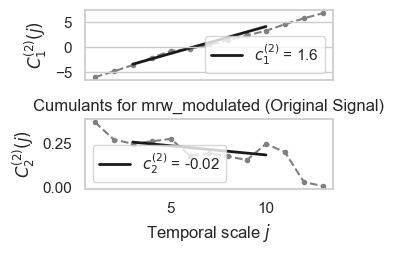

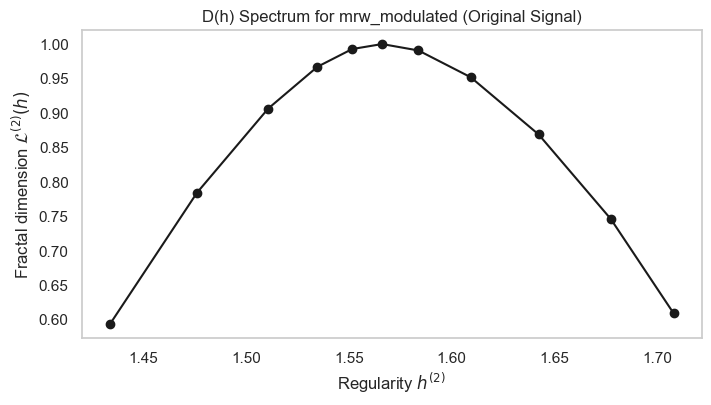

Loaded modes shape: (9, 82500) for mrw_modulated / EMD


<Figure size 800x400 with 0 Axes>

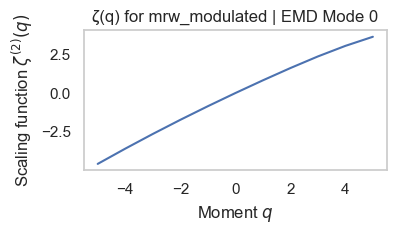

<Figure size 800x400 with 0 Axes>

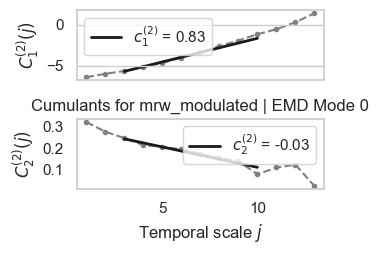

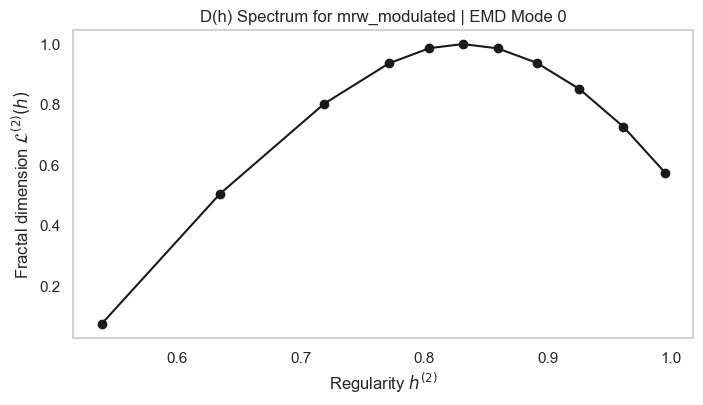

<Figure size 800x400 with 0 Axes>

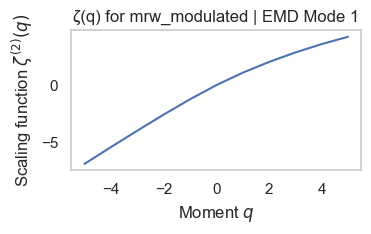

<Figure size 800x400 with 0 Axes>

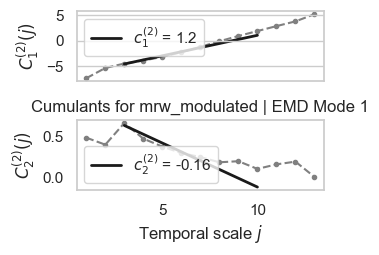

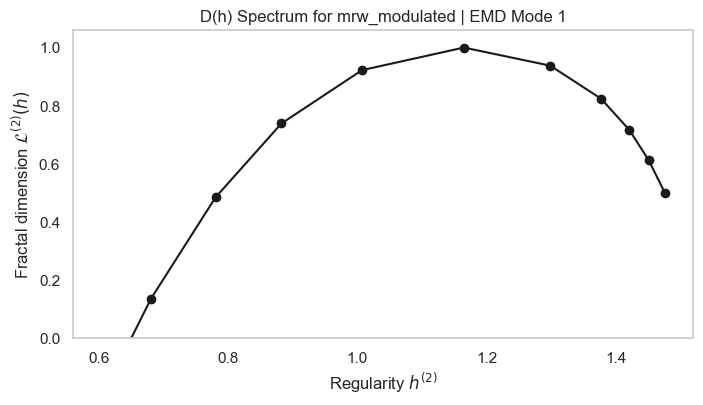

<Figure size 800x400 with 0 Axes>

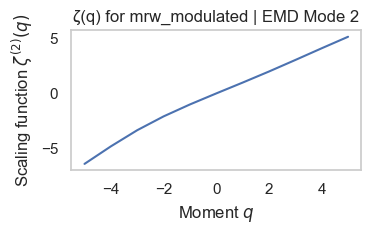

<Figure size 800x400 with 0 Axes>

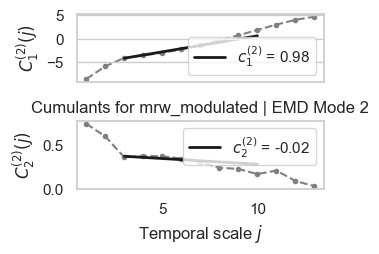

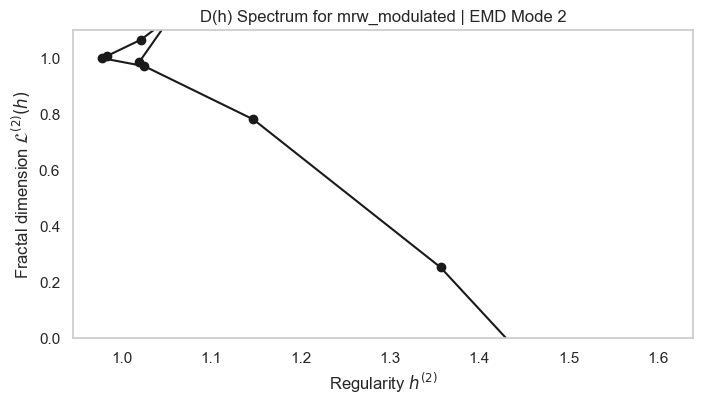

<Figure size 800x400 with 0 Axes>

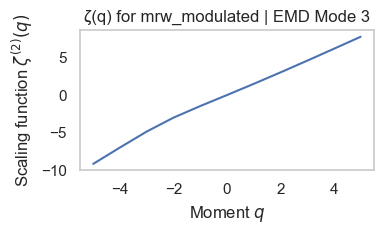

<Figure size 800x400 with 0 Axes>

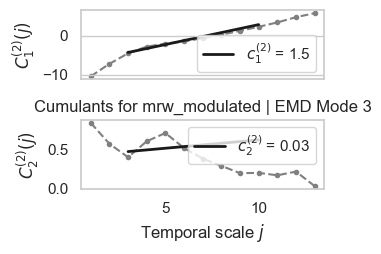

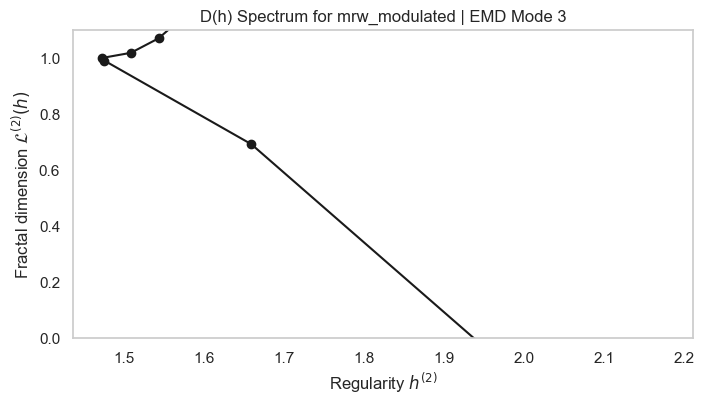

<Figure size 800x400 with 0 Axes>

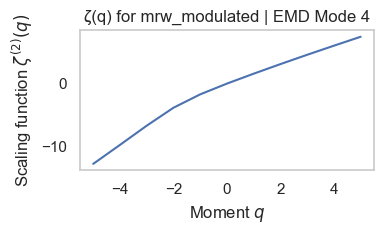

<Figure size 800x400 with 0 Axes>

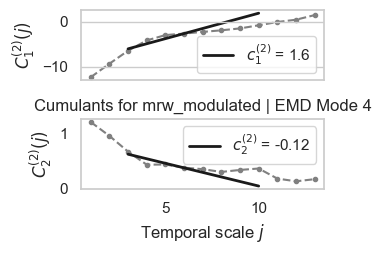

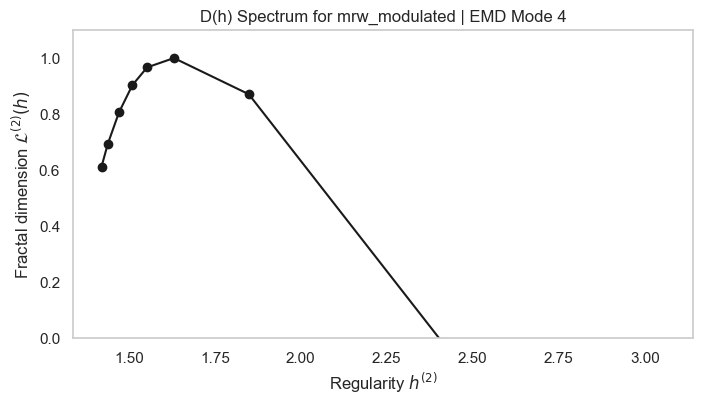

<Figure size 800x400 with 0 Axes>

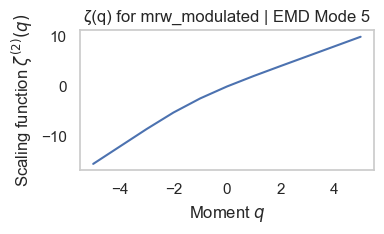

<Figure size 800x400 with 0 Axes>

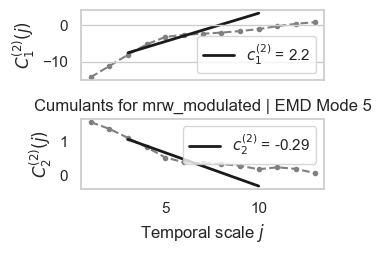

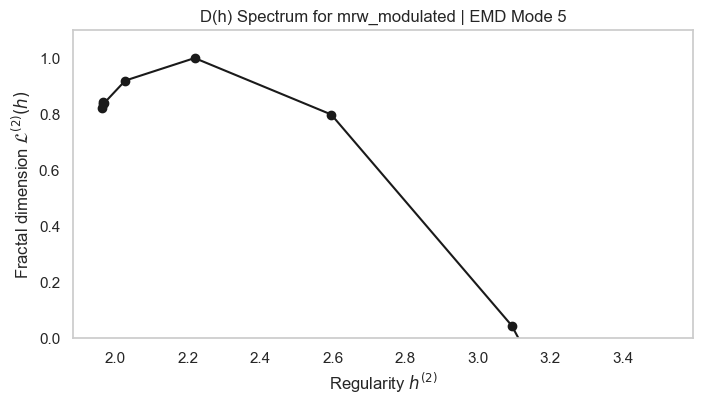

<Figure size 800x400 with 0 Axes>

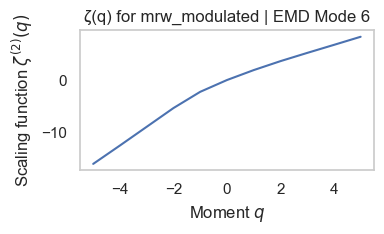

<Figure size 800x400 with 0 Axes>

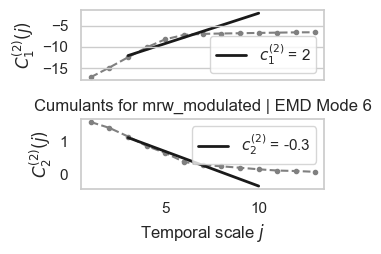

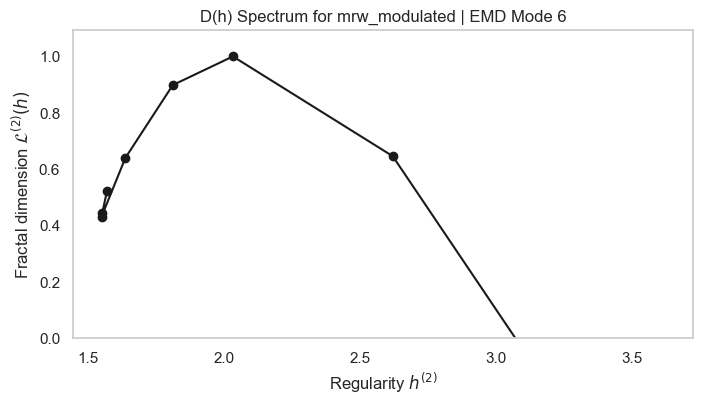

<Figure size 800x400 with 0 Axes>

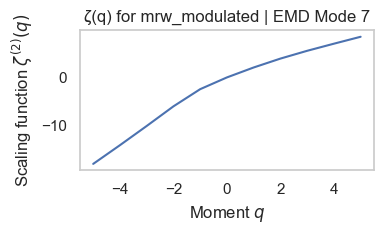

<Figure size 800x400 with 0 Axes>

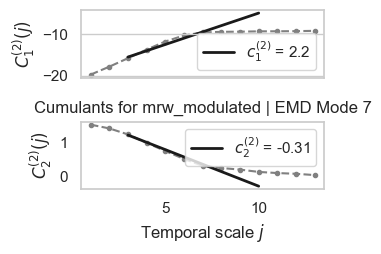

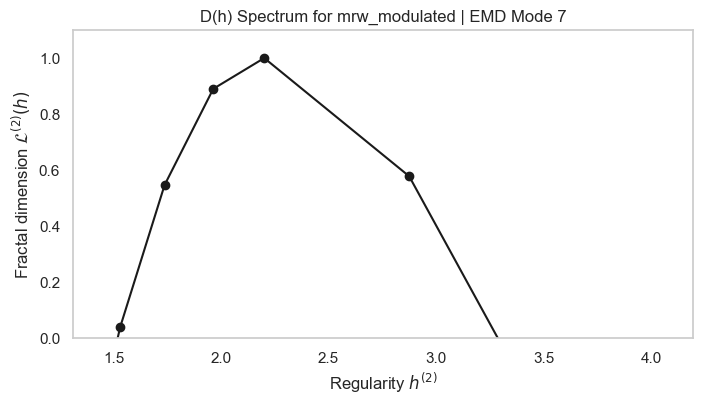

<Figure size 800x400 with 0 Axes>

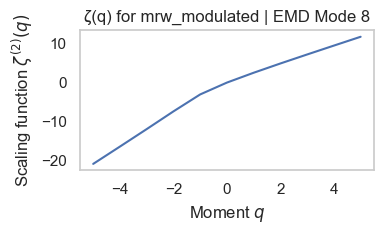

<Figure size 800x400 with 0 Axes>

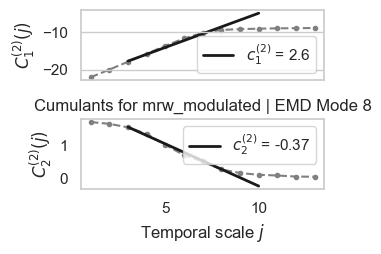

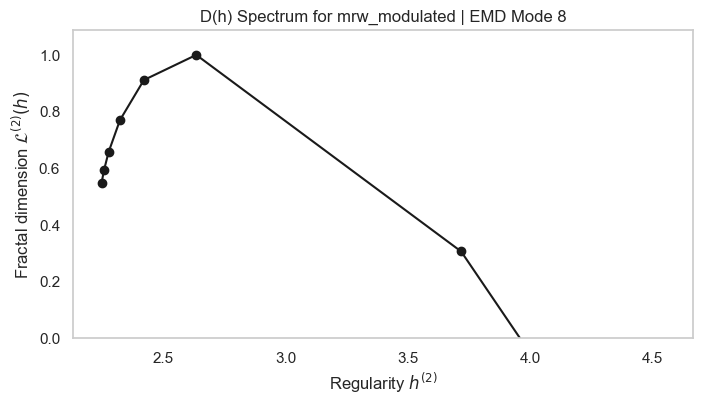

Processing signal: mrw_with_fbm


<Figure size 800x400 with 0 Axes>

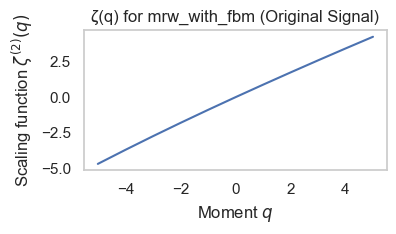

<Figure size 800x400 with 0 Axes>

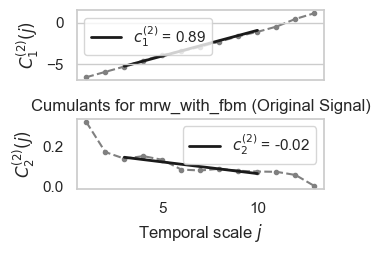

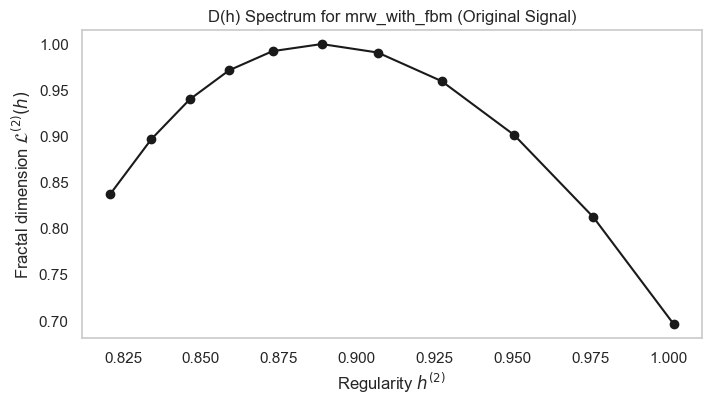

Loaded modes shape: (9, 82500) for mrw_with_fbm / EMD


<Figure size 800x400 with 0 Axes>

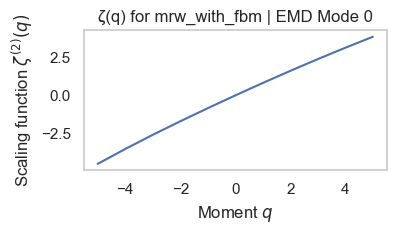

<Figure size 800x400 with 0 Axes>

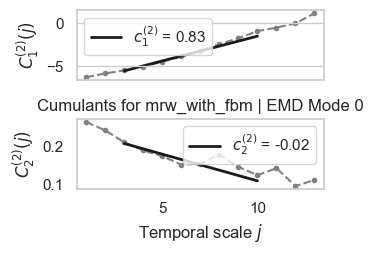

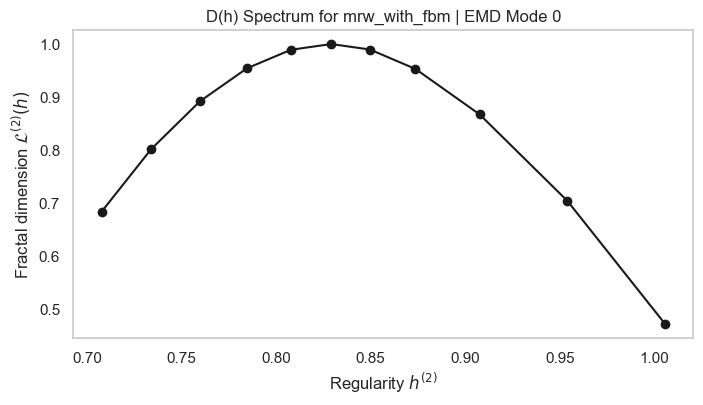

<Figure size 800x400 with 0 Axes>

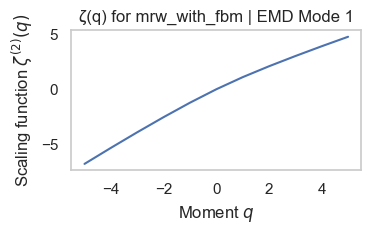

<Figure size 800x400 with 0 Axes>

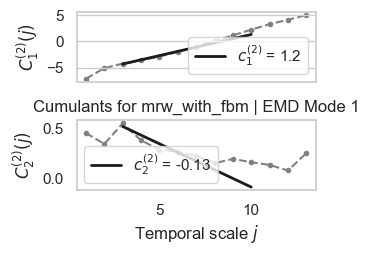

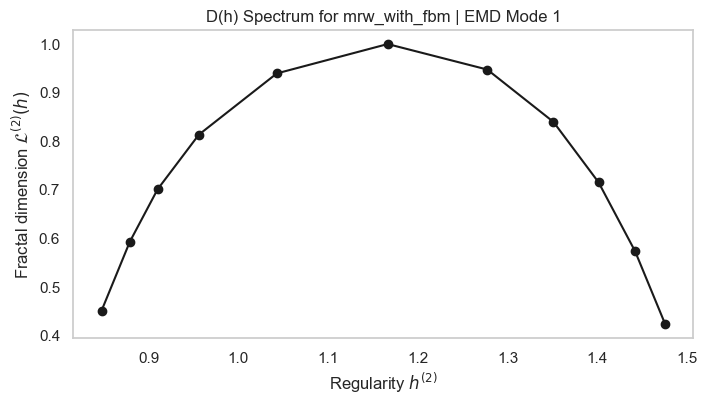

<Figure size 800x400 with 0 Axes>

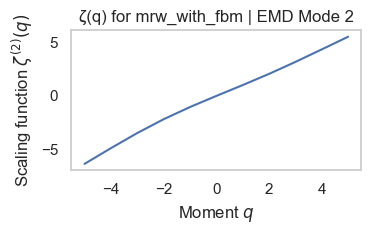

<Figure size 800x400 with 0 Axes>

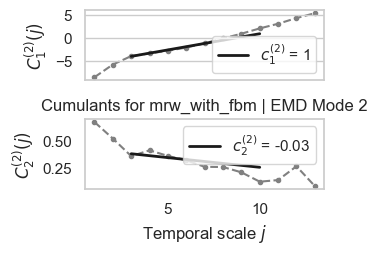

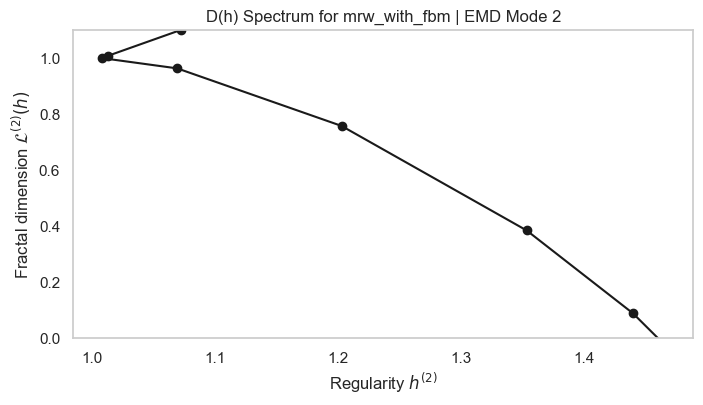

<Figure size 800x400 with 0 Axes>

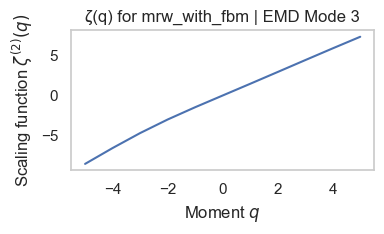

<Figure size 800x400 with 0 Axes>

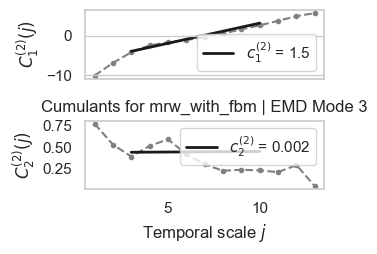

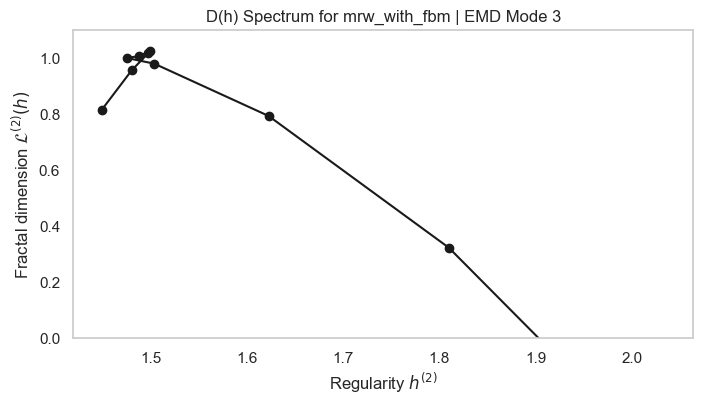

<Figure size 800x400 with 0 Axes>

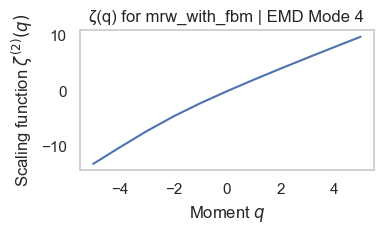

<Figure size 800x400 with 0 Axes>

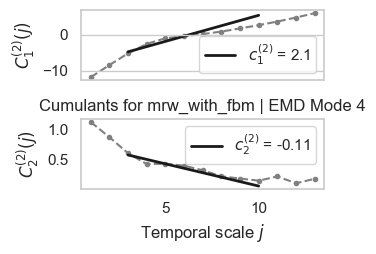

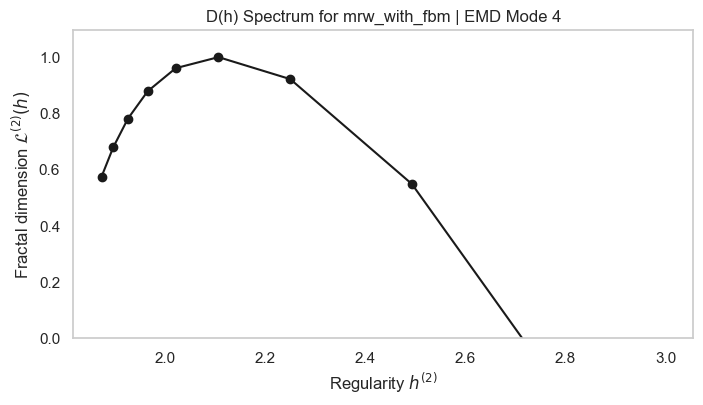

<Figure size 800x400 with 0 Axes>

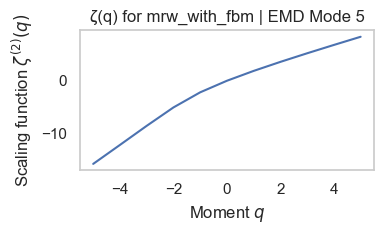

<Figure size 800x400 with 0 Axes>

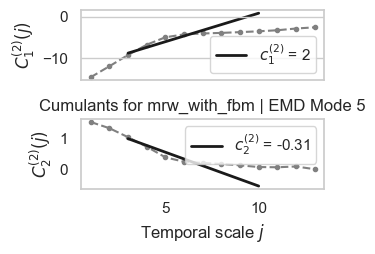

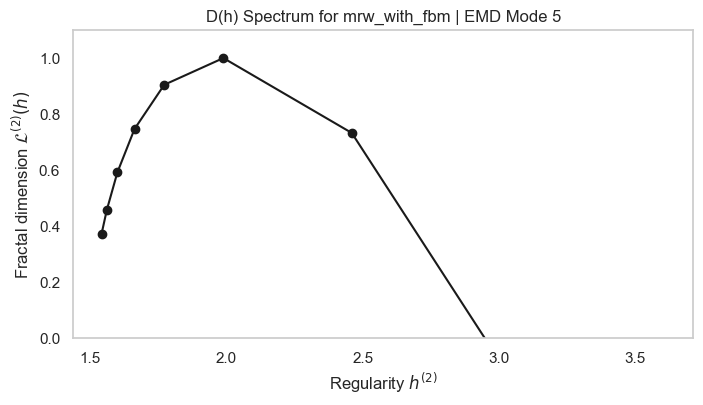

<Figure size 800x400 with 0 Axes>

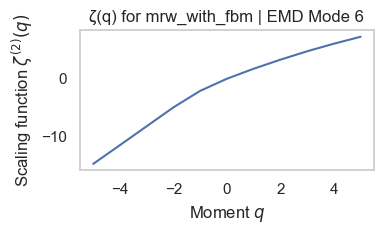

<Figure size 800x400 with 0 Axes>

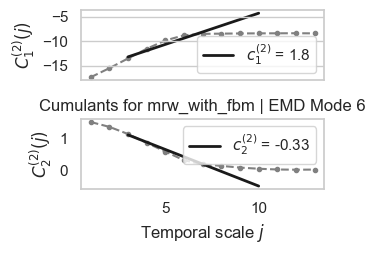

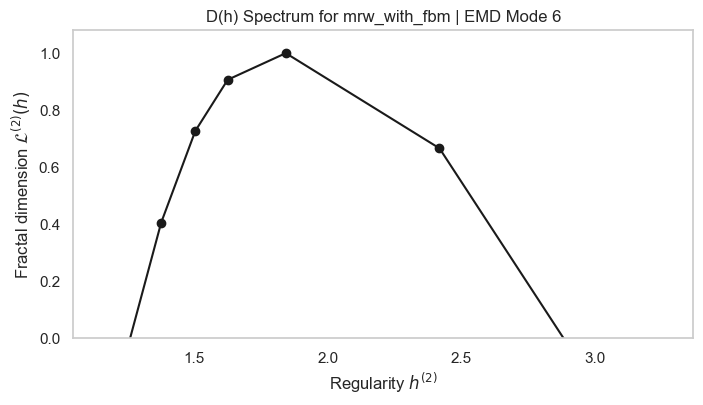

<Figure size 800x400 with 0 Axes>

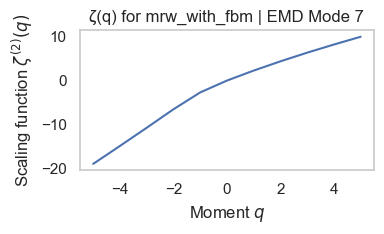

<Figure size 800x400 with 0 Axes>

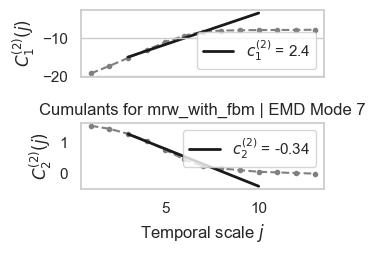

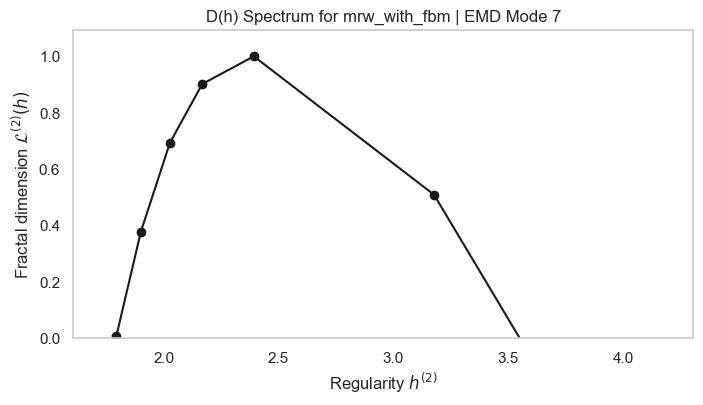

<Figure size 800x400 with 0 Axes>

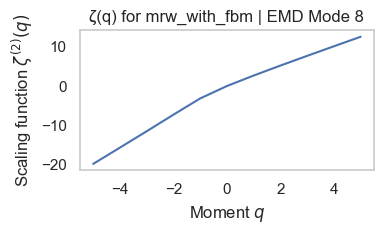

<Figure size 800x400 with 0 Axes>

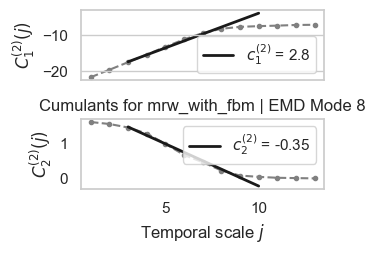

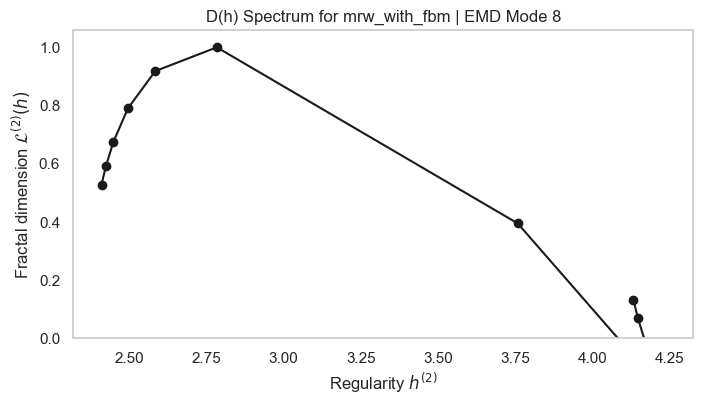

In [286]:
scaling_ranges = [(3, 10)]  
q_vals = np.arange(-5, 6)
summary_records = []
methods = ["VMD","EMD"]

for signal, name in zip(signal_list, signal_names):
    if name is not "pure":
        print(f"Processing signal: {name}")

        # Apply MFA on original signal
        pwt_signal = compute_mfa(signal, scaling_ranges, q_vals)
        plot_mfa(pwt_signal, ch_label=f"{name} (Original Signal)")

        # Collect cumulants summary for original signal
        summary_records.append({
            "Signal": name,
            "Mode": "Original",
            "Log-cumulant 1": pwt_signal.cumulants.values[0],
            "Log-cumulant 2": pwt_signal.cumulants.values[1]
        })

        for method in methods:
            modes_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")

            if not os.path.exists(modes_path):
                print(f"Modes not found for {name} / {method} at {modes_path}")
                continue

            modes = np.load(modes_path)
            print(f"Loaded modes shape: {modes.shape} for {name} / {method}")

            for idx, mode in enumerate(modes):
                pwt_mode = compute_mfa(mode, scaling_ranges, q_vals)
                plot_mfa(pwt_mode, ch_label=f"{name} | {method} Mode {idx}")
                summary_records.append({
                    "Signal": name,
                    "Mode": f"{method} Mode {idx}",
                    "Log-cumulant 1": pwt_mode.cumulants.values[0],
                    "Log-cumulant 2": pwt_mode.cumulants.values[1]
                })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_records)
# Optionally save summary to CSV
summary_df.to_csv(os.path.join(output_base, "mfa_log_cumulants_summary.csv"), index=False)


In [285]:
summary_df

Signal        Mode  \
0   mrw_modulated    Original   
1   mrw_modulated  VMD Mode 0   
2   mrw_modulated  VMD Mode 1   
3   mrw_modulated  VMD Mode 2   
4   mrw_modulated  VMD Mode 3   
5   mrw_modulated  VMD Mode 4   
6    mrw_with_fbm    Original   
7    mrw_with_fbm  VMD Mode 0   
8    mrw_with_fbm  VMD Mode 1   
9    mrw_with_fbm  VMD Mode 2   
10   mrw_with_fbm  VMD Mode 3   
11   mrw_with_fbm  VMD Mode 4   

                                       Log-cumulant 1  \
0   [[[-6.050951192045323]], [[-4.869291744163444]...   
1   [[[-11.211981734925917]], [[-10.32882836126910...   
2   [[[-8.701741977959683]], [[-5.240603867277691]...   
3   [[[-6.07942196033599]], [[-1.8174832643439647]...   
4   [[[-4.63201284644294]], [[-2.2255850681399156]...   
5   [[[-5.110731052107781]], [[-4.519424421303419]...   
6   [[[-6.574837400680047]], [[-5.933320739945995]...   
7   [[[-11.508772703585533]], [[-9.923572522502251...   
8   [[[-6.657782588460689]], [[-2.569150351543657]...   
9   [[[-5.920403866826006]], [[-2.570042820720065]...   
10  [[[-4.93109612342598]], [[-2.988671038391345]]...   
11  [[[-5.310061865655728]], [[-5.058845451707566]...   

                                       Log-cumulant 2  
0   [[[0.3754694417653184]], [[0.2748661861780022]...  
1   [[[0.469651161529697]], [[0.2865180968069154]]...  
2   [[[0.4232220736968344]], [[0.36134007128224965...  
3   [[[0.36553807869790234]], [[0.4500825059871349...  
4   [[[0.44434847562509816]], [[0.3473592855931997...  
5   [[[0.5227717018995826]], [[0.2529838582282693]...  
6   [[[0.32119870051533184]], [[0.171098064963914]...  
7   [[[0.2773634298863783]], [[0.2587066931698132]...  
8   [[[0.35594576963236335]], [[0.5478557343499055...  
9   [[[0.5077431906433603]], [[0.29799508819559417...  
10  [[[0.42389919564894996]], [[0.3322181856311808...  
11  [[[0.42074361543045313]], [[0.2248951874416072...

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
# from PyEMD import EMD

# # Time axis
# fs = 1000
# t = np.linspace(0, 1, fs)

# # True components
# c1 = np.sin(2 * np.pi * 5 * t)
# c2 = np.sin(2 * np.pi * 20 * t)
# c3 = np.sin(2 * np.pi * 60 * t)
# signal = c1 + c2 + c3

# # EMD decomposition
# emd = EMD()
# imfs = emd.emd(signal, t)

# # Plot
# fig, axes = plt.subplots(5, 1, figsize=(12, 8), sharex=True)
# fig.suptitle("Empirical Mode Decomposition (EMD)", fontsize=14)

# axes[0].plot(t, signal, color='black')
# axes[0].set_ylabel("Original Signal")

# axes[1].plot(t, c1, label='5 Hz', linestyle='--')
# axes[1].plot(t, c2, label='20 Hz', linestyle='-.')
# axes[1].plot(t, c3, label='60 Hz', linestyle=':')
# axes[1].legend()
# axes[1].set_ylabel("True Components")

# for i in range(min(3, imfs.shape[0])):
#     axes[i+2].plot(t, imfs[i])
#     axes[i+2].set_ylabel(f"IMF {i+1}")

# axes[-1].set_xlabel("Time (s)")
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()


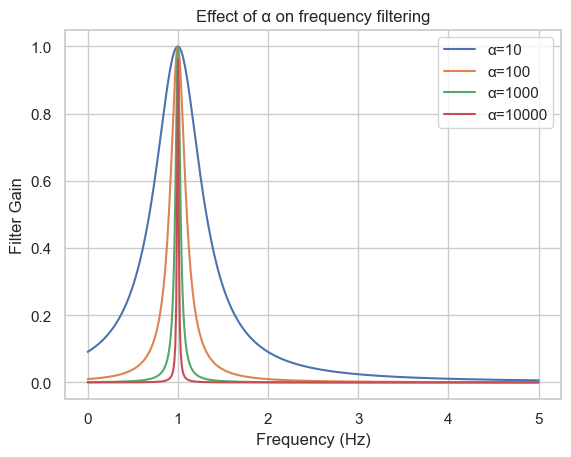

In [325]:
import numpy as np
import matplotlib.pyplot as plt

ω = np.linspace(0, 5, 500)
α_values = [10, 100, 1000, 10000]
ω_k = 1

for α in α_values:
    d = 1 + α * (ω - ω_k)**2
    plt.plot(ω, 1/d, label=f'α={α}')

plt.title("Effect of α on frequency filtering")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Filter Gain")
plt.legend()
plt.grid(True)
plt.show()
